# Black-box optimization exercise

## Introduction

This is part of the capstone project for the Professional Certificate in Machine Learning and AI from Imperial College Business School.

The goal is the optimization of 8 black-box functions. For each of the functions 10 initial data points are given and each week I must submit a new data point to evaluate. This simulates a costly process of actual evaluation.

All variables range from 0 to 1.

This notebook will document the whole process.



In [1]:
# Environment preparation

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C, Matern
from sklearn.ensemble import ExtraTreesRegressor
from scipy.optimize import minimize
from skopt import forest_minimize
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
import ast, re


results_df = pd.DataFrame(columns=['week', 'function', 'known_best', 'provided_input', 'output', 'submission_improved'])

# Load initial values
for X in range(1, 9):
    inputs_path = f"initial_data/function_{X}/initial_inputs.npy"
    outputs_path = f"initial_data/function_{X}/initial_outputs.npy"
    
    globals()[f"f{X}_inputs"] = np.load(inputs_path)
    globals()[f"f{X}_outputs"] = np.load(outputs_path)

    results_df.loc[len(results_df)] = [0, X, np.max(globals()[f"f{X}_outputs"]), globals()[f"f{X}_inputs"][np.argmax(globals()[f"f{X}_outputs"])], np.nan, False]

# Load results dataframe with each weeks inputs and outputs
#for X in range(1,3):
inputs_path = f"submissions/w2_inputs.txt"
outputs_path = f"submissions/w2_outputs.txt"

#Inputs
with open(inputs_path, 'r') as file:
    content = file.read()

# Split out the separate sets
raw_sets = re.split(r'\]\s*\[', content.strip())
raw_sets = [s.strip('[]') for s in raw_sets]

# Parse each set into lists of numpy arrays
all_sets = []
for s in raw_sets:
    print(f"First match {s}")
    arrays_raw = re.findall(r'array\((.*?)\)', s, re.DOTALL)
    instance_set = [np.array(eval(a)) for a in arrays_raw]
    all_sets.append(instance_set)

# Transpose structure: arrays[i] has i-th array of each set
max_len = max(len(s) for s in all_sets)
arrays = []
for i in range(max_len):
    group = []
    for n, s in enumerate(all_sets, start=1):
        if i < len(s):
            #week number, function, best_output, provided_input, output, submission_improved
            results_df.loc[len(results_df)] = [n, i+1, np.nan, s[i], np.nan, False]
    
#Outputs
with open(outputs_path, 'r') as file:
    for line_number, line in enumerate(file, start=1):
        content = line.strip()

        # Replace 'np.float64(' and ')' so the string only has floats, then use ast.literal_eval for safety
        content_clean = content.replace('np.float64(', '').replace(')', '')
        float_list = ast.literal_eval(f'[{content_clean}]')

        outputs = np.array(float_list, dtype=np.float64)

        # for each function
        for i in range(0,8):
            #Determine if the submission if best than the known best previous week (hence the -1)
            row = results_df[(results_df['week'] == line_number-1) & (results_df['function'] == i+1)]
            known_best = row['known_best'].values[0]
        
            improved = (outputs[0,i] > known_best)
            if improved:
                known_best = outputs[0,i]
            # populate the dataframe
            condition = (results_df['week'] == line_number) & (results_df['function'] == i+1)
            results_df.loc[condition, 'submission_improved'] = improved
            results_df.loc[condition, 'known_best'] = known_best
            results_df.loc[condition, 'output'] = outputs[0,i]



First match array([0.373737, 0.232323]), array([0.818182, 0.979798]), array([0.172414, 0.206897, 0.206897]), array([0.448276, 0.413793, 0.37931 , 0.37931 ]), array([0.586207, 0.62069 , 1.      , 0.931034]), array([0.      , 0.655172, 0.103448, 0.931034, 0.275862]), array([0.014182, 0.276863, 0.738085, 0.05311 , 0.37586 , 0.79945 ]), array([0.053588, 0.199773, 0.0651  , 0.022307, 0.890284, 0.392617,
       0.053845, 0.582385])
First match array([0.989899, 0.767677]), array([0.707071, 0.10101 ]), array([0.862069, 0.137931, 0.655172]), array([0.413793, 0.413793, 0.344828, 0.413793]), array([0.894898, 0.105102, 0.894898, 0.894898]), array([0.517241, 0.310345, 0.517241, 0.862069, 0.103448]), array([0.016974, 0.324003, 0.154628, 0.172541, 0.388943, 0.758898]), array([0.076967, 0.216041, 0.229342, 0.023042, 0.977037, 0.446917,
       0.188639, 0.130387])


In [2]:
results_df.sort_values(by=['function', 'week'])

results_df[results_df['week'] == 2]

,week,function,known_best,provided_input,output,submission_improved
9,2,1,7.710875e-16,"[0.989899, 0.767677]",-3.043130e-105,False
11,2,2,6.112052e-01,"[0.707071, 0.10101]",5.755701e-01,False
13,2,3,-3.483531e-02,"[0.862069, 0.137931, 0.655172]",-1.405773e-01,False
15,2,4,6.230694e-01,"[0.413793, 0.413793, 0.344828, 0.413793]",6.230694e-01,True
17,2,5,1.687380e+03,"[0.894898, 0.105102, 0.894898, 0.894898]",1.488865e+03,False
19,2,6,-4.072034e-01,"[0.517241, 0.310345, 0.517241, 0.862069, 0.103...",-4.072034e-01,True
21,2,7,1.599912e+00,"[0.016974, 0.324003, 0.154628, 0.172541, 0.388...",1.599912e+00,True
23,2,8,9.908052e+00,"[0.076967, 0.216041, 0.229342, 0.023042, 0.977...",9.908052e+00,True


This kind of problem is the textbook example of usage of Bayesian optimization. 

In this kind of problem the most widely used surrogate function is a Gaussian process because, among other things, it already comes with uncertainty measures embedded. I will be testing our different kernels and acquisition functions depending on the case at hand. The litterature suggests applying. Automatic relevance determination (ARD) to the kernels which allows for differnet "length scale" for each dimension. (https://www.pnas.org/doi/10.1073/pnas.1912342117)

## Function 1

This function is a function with a 1D output and a 2D input. 

This is the description of the function: Detect likely contamination sources in a two-dimensional area, such as a radiation field, where only proximity yields a non-zero reading. The system uses Bayesian optimisation to tune detection parameters and reliably identify both strong and weak sources.

### Week 1

This is a 2D function, so we can start by plotting the known datapoints

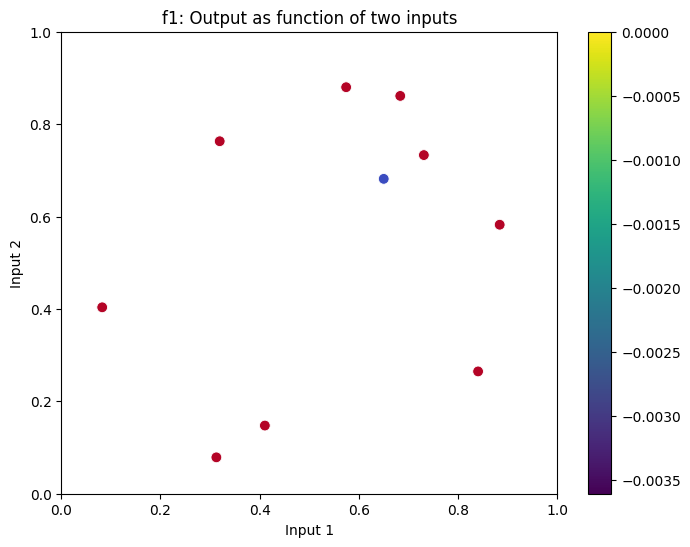

Evaluations: 10
Inputs shape: (10, 2)
Inputs range: [0.0787, 0.8839]
Performance range: [-3.6061e-03, 7.7109e-16]
Current best: 7.7109e-16
Inputs producing current best: [0.73102363 0.73299988]


In [3]:
x1 = f1_inputs[:, 0]
x2 = f1_inputs[:, 1]
y = f1_outputs

# Put data into a DataFrame
df = pd.DataFrame({
    "x1": x1,
    "x2": x2,
    "y": y
})

# Scatter plot with color encoding the output
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="x1", y="x2", hue="y", palette="coolwarm", s=60, legend=False)
plt.title("f1: Output as function of two inputs")
plt.xlabel("Input 1")
plt.ylabel("Input 2")
plt.xlim(0, 1)
plt.ylim(0, 1)
norm = plt.Normalize(vmin=y.min(), vmax=y.max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
plt.colorbar(sm, ax=plt.gca())
plt.show()


print(f"Evaluations: {len(f1_inputs)}")
print(f"Inputs shape: {f1_inputs.shape}")
print(f"Inputs range: [{np.min(f1_inputs):.4f}, {np.max(f1_inputs):.4f}]")
print(f"Performance range: [{np.min(f1_outputs):.4e}, {np.max(f1_outputs):.4e}]")
print(f"Current best: {np.max(f1_outputs):.4e}")
print(f"Inputs producing current best: {f1_inputs[np.argmax(f1_outputs)]}")

Most values are rather on the lower end, which is normal because radiation will be low outside the contaminated area. Peaks are expected to be localized.

We can try a Matern kernel in a Gaussian process regressor to consider that data is not smooth, with a smart selection of nu. If nu tends to infinity, then this behaves as a RBF kernel (reference: https://andrewcharlesjones.github.io/journal/matern-kernels.html). We will initially try with a nu of 1.5

h:\Projects\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
h:\Projects\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


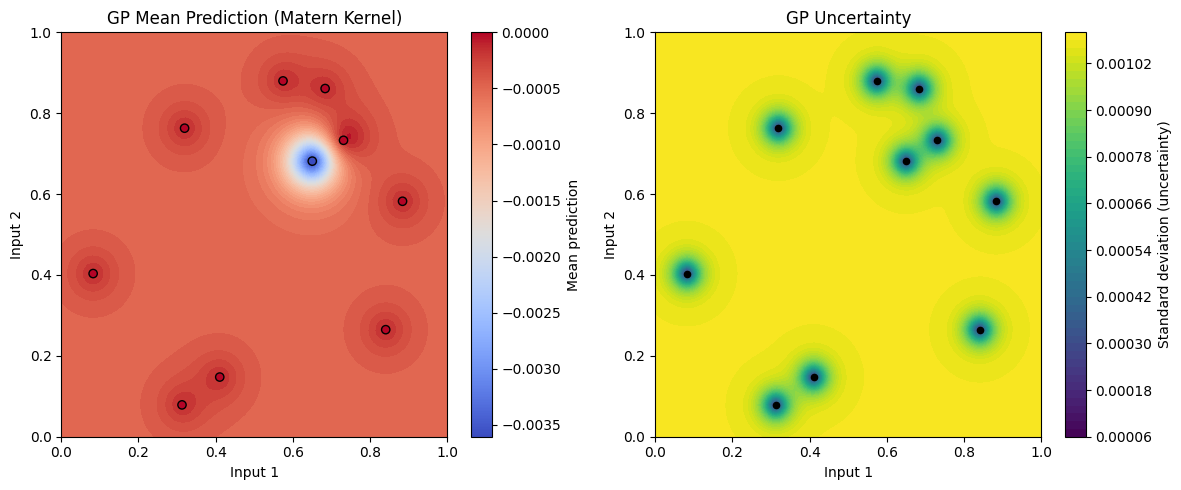

In [4]:
kernel = Matern(length_scale=[0.1, 0.1], length_scale_bounds=(0.05, 0.5), nu=1.5)
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=20,
    alpha=1e-6, #modelling noise     
    normalize_y=True,
    random_state=42
)
gp.fit(f1_inputs, f1_outputs)

x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)
X1, X2 = np.meshgrid(x1, x2)
X_grid = np.column_stack([X1.ravel(), X2.ravel()])

y_mean, y_std = gp.predict(X_grid, return_std=True)
Y_mean = y_mean.reshape(X1.shape)
Y_std = y_std.reshape(X1.shape)

# Plot mean
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.contourf(X1, X2, Y_mean, cmap='coolwarm', levels=50)
plt.scatter(f1_inputs[:,0], f1_inputs[:,1], c=f1_outputs, cmap='coolwarm', edgecolor='k')
plt.colorbar(label='Mean prediction')
plt.title("GP Mean Prediction (Matern Kernel)")
plt.xlabel("Input 1")
plt.ylabel("Input 2")

# Plot uncertainty
plt.subplot(1,2,2)
plt.contourf(X1, X2, Y_std, cmap='viridis', levels=50)
plt.colorbar(label='Standard deviation (uncertainty)')
plt.scatter(f1_inputs[:,0], f1_inputs[:,1], c='k', s=20)
plt.title("GP Uncertainty")
plt.xlabel("Input 1")
plt.ylabel("Input 2")

plt.tight_layout()
plt.show()

I am getting warnings about the optimal values being to close to the bounds provided, so let's try again with new values.

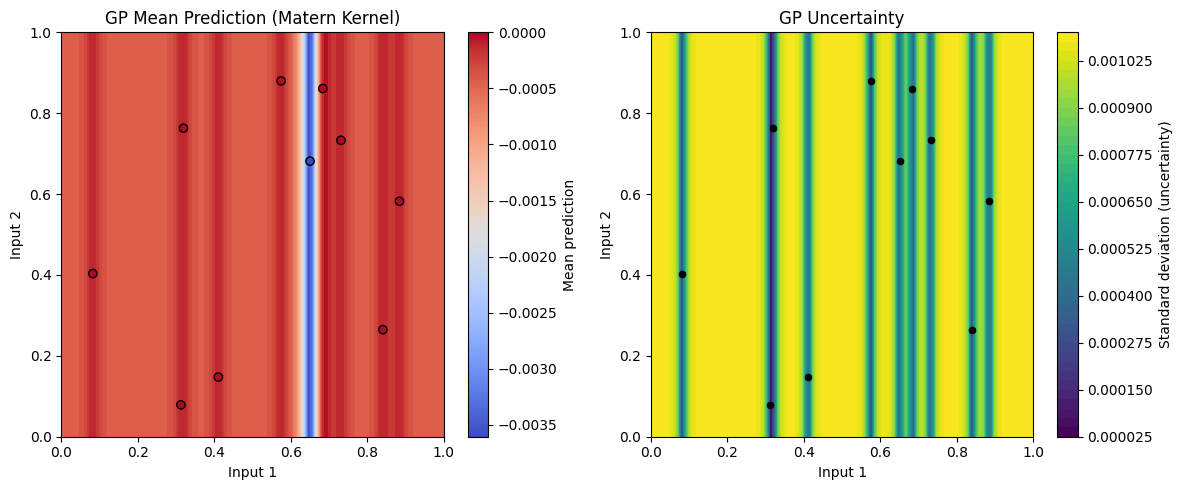

In [5]:

kernel = Matern(length_scale=[0.1, 0.1], length_scale_bounds=(1e-2, 1e5), nu=1.5)
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=20,
    alpha=1e-6, #modelling noise     
    normalize_y=True,
    random_state=42
)
gp.fit(f1_inputs, f1_outputs)

x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)
X1, X2 = np.meshgrid(x1, x2)
X_grid = np.column_stack([X1.ravel(), X2.ravel()])

y_mean, y_std = gp.predict(X_grid, return_std=True)
Y_mean = y_mean.reshape(X1.shape)
Y_std = y_std.reshape(X1.shape)

# Plot mean
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.contourf(X1, X2, Y_mean, cmap='coolwarm', levels=50)
plt.scatter(f1_inputs[:,0], f1_inputs[:,1], c=f1_outputs, cmap='coolwarm', edgecolor='k')
plt.colorbar(label='Mean prediction')
plt.title("GP Mean Prediction (Matern Kernel)")
plt.xlabel("Input 1")
plt.ylabel("Input 2")

# Plot uncertainty
plt.subplot(1,2,2)
plt.contourf(X1, X2, Y_std, cmap='viridis', levels=50)
plt.colorbar(label='Standard deviation (uncertainty)')
plt.scatter(f1_inputs[:,0], f1_inputs[:,1], c='k', s=20)
plt.title("GP Uncertainty")
plt.xlabel("Input 1")
plt.ylabel("Input 2")

plt.tight_layout()
plt.show()

As this is a problem that must encourage exploration, let's use a UCB acquisition function, with a choice of k = 3.

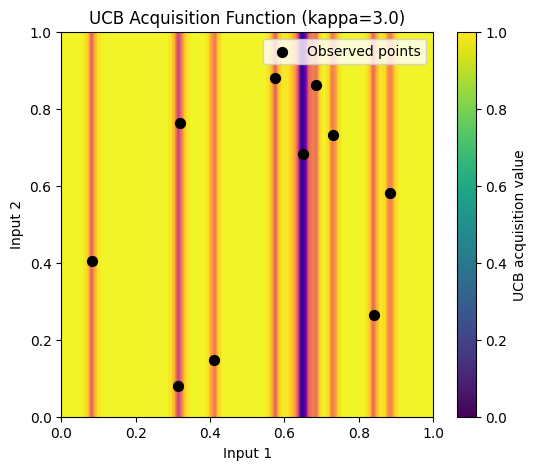

In [6]:
kappa = 3.0
UCB = Y_mean + kappa * Y_std  # shape = (grid_size, grid_size)

plt.figure(figsize=(6,5))
plt.contourf(X1, X2, UCB, cmap='plasma', levels=50)
plt.scatter(f1_inputs[:,0], f1_inputs[:,1], c='k', s=50, label='Observed points')
plt.colorbar(label='UCB acquisition value')
plt.title(f"UCB Acquisition Function (kappa={kappa})")
plt.xlabel("Input 1")
plt.ylabel("Input 2")
plt.legend()
plt.show()

In [7]:
max_idx = np.argmax(UCB)  # index of the maximum UCB
next_point = X_grid[max_idx]  # coordinates in input space

print(f"Current best: {np.max(f1_outputs):.4e}")
print(f"Inputs producing current best: {f1_inputs[np.argmax(f1_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

# With the other bounds the suggested submission was 0.78787879 0.7979798

Current best: 7.7109e-16
Inputs producing current best: [0.73102363 0.73299988]
Next point to sample based on UCB: [0.37373737 0.23232323]
0.373737-0.232323


Submission for week 1: 0.373737-0.232323

### Week 2

In [8]:
#Load points to inputs and outputs from previous week
function = 1
week = 1 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f1_inputs = np.vstack([f1_inputs, row['provided_input'].values[0]])
f1_outputs = np.append(f1_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f1_outputs):.4e}")
print(f"Last week's results: {row['output'].values[0]:.4e}")


Submission from last week improved something? False
Current best: 7.7109e-16
Last week's results: -3.4258e-28


Let's try the same thing but adjusting the surrogate function so that the importance is given to both parameters. UCB as acquisition function favors exploration, which is what we want at this point.

h:\Projects\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 0.3. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


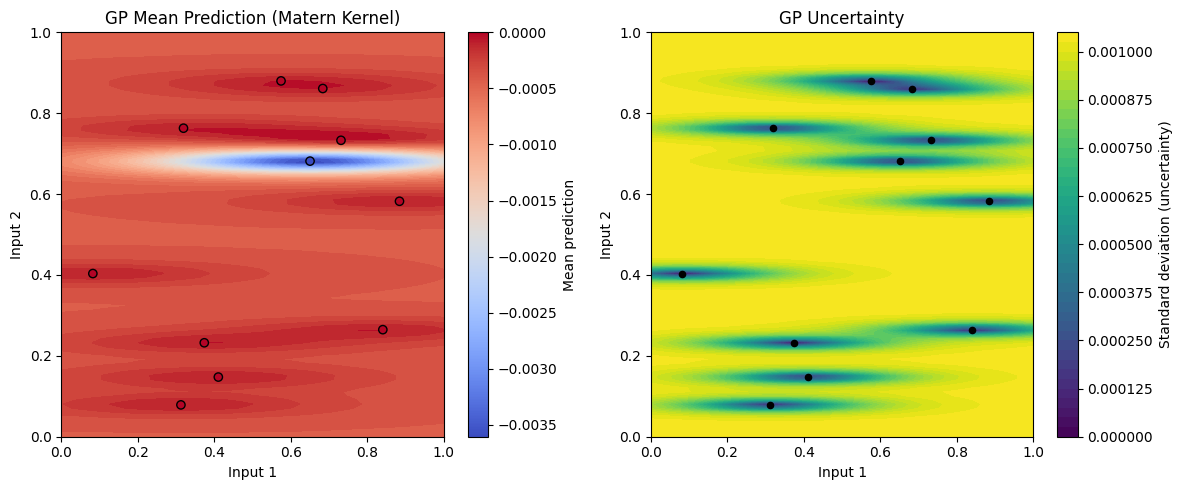

In [9]:

kernel = C(1.0, (1e-5, 1e5)) * Matern(length_scale=[0.05, 0.05], length_scale_bounds=(0.01, 0.3), nu=2.5) + WhiteKernel(noise_level=1e-8, noise_level_bounds=(1e-12, 1e2))
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=50,
    alpha=1e-6, #modelling noise     
    normalize_y=True,
    random_state=42
)
gp.fit(f1_inputs, f1_outputs)

x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)
X1, X2 = np.meshgrid(x1, x2)
X_grid = np.column_stack([X1.ravel(), X2.ravel()])

y_mean, y_std = gp.predict(X_grid, return_std=True)
Y_mean = y_mean.reshape(X1.shape)
Y_std = y_std.reshape(X1.shape)

# Plot mean
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.contourf(X1, X2, Y_mean, cmap='coolwarm', levels=50)
plt.scatter(f1_inputs[:,0], f1_inputs[:,1], c=f1_outputs, cmap='coolwarm', edgecolor='k')
plt.colorbar(label='Mean prediction')
plt.title("GP Mean Prediction (Matern Kernel)")
plt.xlabel("Input 1")
plt.ylabel("Input 2")

# Plot uncertainty
plt.subplot(1,2,2)
plt.contourf(X1, X2, Y_std, cmap='viridis', levels=50)
plt.colorbar(label='Standard deviation (uncertainty)')
plt.scatter(f1_inputs[:,0], f1_inputs[:,1], c='k', s=20)
plt.title("GP Uncertainty")
plt.xlabel("Input 1")
plt.ylabel("Input 2")

plt.tight_layout()
plt.show()

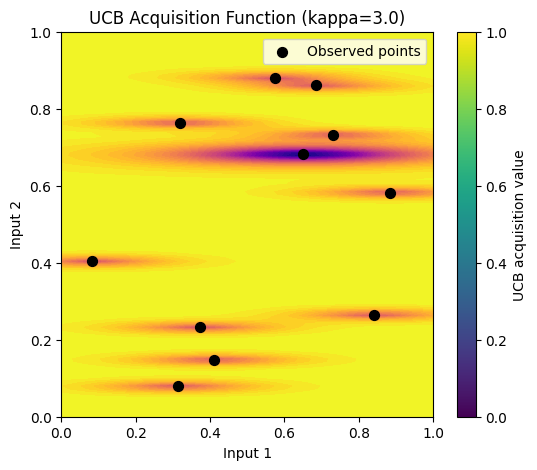

In [10]:
kappa = 3.0
UCB = Y_mean + kappa * Y_std  # shape = (grid_size, grid_size)

plt.figure(figsize=(6,5))
plt.contourf(X1, X2, UCB, cmap='plasma', levels=50)
plt.scatter(f1_inputs[:,0], f1_inputs[:,1], c='k', s=50, label='Observed points')
plt.colorbar(label='UCB acquisition value')
plt.title(f"UCB Acquisition Function (kappa={kappa})")
plt.xlabel("Input 1")
plt.ylabel("Input 2")
plt.legend()
plt.show()

In [11]:
max_idx = np.argmax(UCB)  # index of the maximum UCB
next_point = X_grid[max_idx]  # coordinates in input space

print(f"Current best: {np.max(f1_outputs):.4e}")
print(f"Inputs producing current best: {f1_inputs[np.argmax(f1_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

Current best: 7.7109e-16
Inputs producing current best: [0.73102363 0.73299988]
Next point to sample based on UCB: [0.98989899 0.76767677]
0.989899-0.767677


Submission for week 2: 0.989899-0.767677

### Week 3

In [12]:
#Load points to inputs and outputs from previous week
function = 1
week = 2 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f1_inputs = np.vstack([f1_inputs, row['provided_input'].values[0]])
f1_outputs = np.append(f1_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f1_outputs):.4e}")
print(f"Last week's results: {row['output'].values[0]:.4e}")
print('--')
print(f"Inputs shape: {f1_inputs.shape}")
print(f"Inputs range: [{np.min(f1_inputs):.4f}, {np.max(f1_inputs):.4f}]")
print(f"Performance range: [{np.min(f1_outputs):.4e}, {np.max(f1_outputs):.4e}]")

Submission from last week improved something? False
Current best: 7.7109e-16
Last week's results: -3.0431e-105
--
Inputs shape: (12, 2)
Inputs range: [0.0787, 0.9899]
Performance range: [-3.6061e-03, 7.7109e-16]


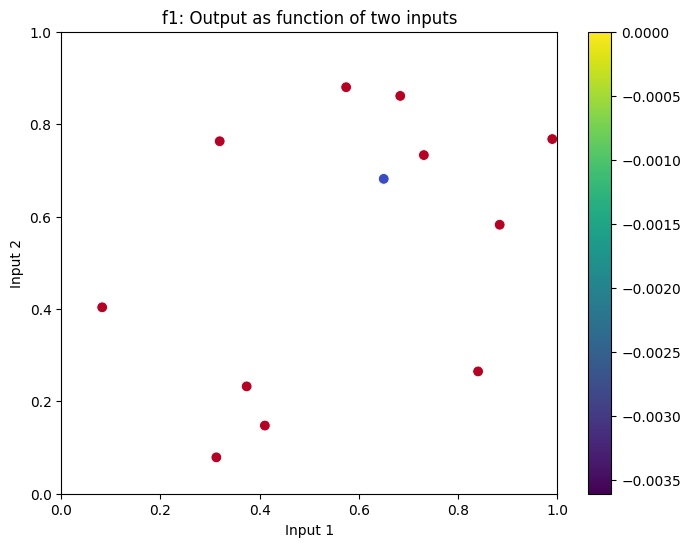

Evaluations: 12
Inputs shape: (12, 2)
Inputs range: [0.0787, 0.9899]
Performance range: [-3.6061e-03, 7.7109e-16]
Current best: 7.7109e-16
Inputs producing current best: [0.73102363 0.73299988]


In [13]:
x1 = f1_inputs[:, 0]
x2 = f1_inputs[:, 1]
y = f1_outputs

# Put data into a DataFrame
df = pd.DataFrame({
    "x1": x1,
    "x2": x2,
    "y": y
})

# Scatter plot with color encoding the output
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="x1", y="x2", hue="y", palette="coolwarm", s=60, legend=False)
plt.title("f1: Output as function of two inputs")
plt.xlabel("Input 1")
plt.ylabel("Input 2")
plt.xlim(0, 1)
plt.ylim(0, 1)
norm = plt.Normalize(vmin=y.min(), vmax=y.max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
plt.colorbar(sm, ax=plt.gca())
plt.show()


print(f"Evaluations: {len(f1_inputs)}")
print(f"Inputs shape: {f1_inputs.shape}")
print(f"Inputs range: [{np.min(f1_inputs):.4f}, {np.max(f1_inputs):.4f}]")
print(f"Performance range: [{np.min(f1_outputs):.4e}, {np.max(f1_outputs):.4e}]")
print(f"Current best: {np.max(f1_outputs):.4e}")
print(f"Inputs producing current best: {f1_inputs[np.argmax(f1_outputs)]}")

We haven't had any improvement for this function so far. It is known that values only peak close to a contamination source. One has already been identified (blue dot above), the goal is to determine if other exist in the 2D plane.

In preparation for more complex cases, I am exploring forest_minimize from skopt which efficiently maximizes the value of the acquisition function. This will help also with high-dimensional cases. I am using a L-BFGS-B (Limited-memory Broyden–Fletcher–Goldfarb–Shanno with Bounds), which according to my limited research is optimal for bounded sets of input values.

In [14]:
# Define kernel: Matern with nu=2.5 for sharp peaks
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[0.2]*2, nu=1.5)

# Instantiate GP with small noise level
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-5, normalize_y=True)

# Fit the GP model
gp.fit(f1_inputs, f1_outputs)
print(gp.kernel_)


# Function to optimize acquisition: Expected Improvement
def acquisitionf(x):
    x = np.array(x).reshape(1, -1)
    mean, std = gp.predict(x, return_std=True)
    # Current best observation
    best_y = np.max(f1_outputs)
    # Calculate EI
    from scipy.stats import norm
    z = (mean - best_y) / (std + 1e-9)
    ei = (mean - best_y) * norm.cdf(z) + std * norm.pdf(z)
    return -ei.item()  

# Robust acquisition maximization via multi-start local optimization
bounds = [(0, 1), (0, 1)]
num_restarts = 1500 # I have incremented this until the estimation did no longer move (fixed random seed)
results = []
np.random.seed(42)

for _ in range(num_restarts):
    x0 = np.random.uniform(0, 1, 2)
    res = minimize(acquisitionf, x0, bounds=bounds, method='L-BFGS-B')
    results.append(res)

print(f"Current best: {np.max(f1_outputs):.4f}")
print(f"Inputs producing current best: {f1_inputs[np.argmax(f1_outputs)]}")

# Select best solution from restarts
next_point = min(results, key=lambda r: r.fun).x
print("Next sample point (local optimizer):", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

1**2 * Matern(length_scale=[0.00684, 0.0127], nu=1.5)
Current best: 0.0000
Inputs producing current best: [0.73102363 0.73299988]
Next sample point (local optimizer): [0.40501878 0.16214521]
0.405019-0.162145


Submission for week 3: 0.405019-0.162145

## Function 2

This function is a function with a 1D output and a 2D input. 

This is the description of the function: Imagine a black box, or a mystery ML model, that takes two numbers as input and returns a log-likelihood score. Your goal is to maximise that score, but each output is noisy, and depending on where you start, you might get stuck in a local optimum. 

To tackle this, you use Bayesian optimisation, which selects the next inputs based on what it has learned so far. It balances exploration with exploitation, making it well suited to noisy outputs and complex functions with many local peaks.

### Week 1

This is a 2D function, so we can start by plotting the known datapoints

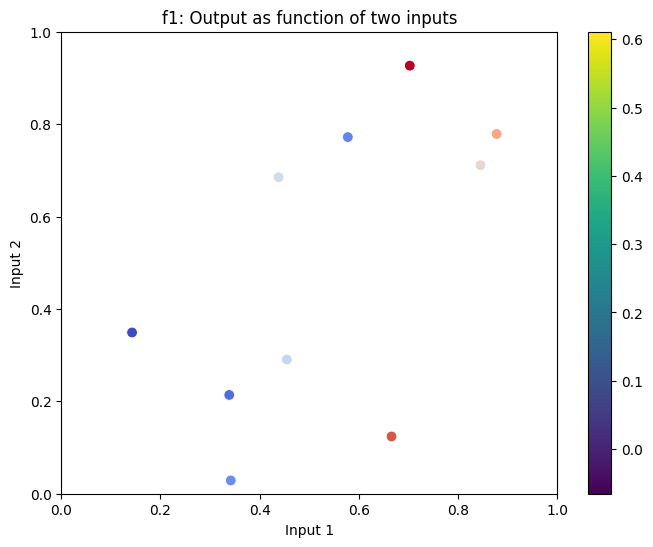

Evaluations: 10
Inputs shape: (10, 2)
Inputs range: [0.0287, 0.9266]
Performance range: [-0.0656, 0.6112]
Current best: 0.6112
Inputs producing current best: [0.70263656 0.9265642 ]


In [15]:
x1 = f2_inputs[:, 0]
x2 = f2_inputs[:, 1]
y = f2_outputs

# Put data into a DataFrame
df = pd.DataFrame({
    "x1": x1,
    "x2": x2,
    "y": y
})

# Scatter plot with color encoding the output
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="x1", y="x2", hue="y", palette="coolwarm", s=60, legend=False)
plt.title("f1: Output as function of two inputs")
plt.xlabel("Input 1")
plt.ylabel("Input 2")
plt.xlim(0, 1)
plt.ylim(0, 1)
norm = plt.Normalize(vmin=y.min(), vmax=y.max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
plt.colorbar(sm, ax=plt.gca())
plt.show()


print(f"Evaluations: {len(f2_inputs)}")
print(f"Inputs shape: {f2_inputs.shape}")
print(f"Inputs range: [{np.min(f2_inputs):.4f}, {np.max(f2_inputs):.4f}]")
print(f"Performance range: [{np.min(f2_outputs):.4f}, {np.max(f2_outputs):.4f}]")
print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Inputs producing current best: {f2_inputs[np.argmax(f2_outputs)]}")



Data feels noisy.

We can try a RBF kernel combined with a WhiteKernel for noise in a Gaussian process regressor to consider that data is smooth as expected in a log likelihood.

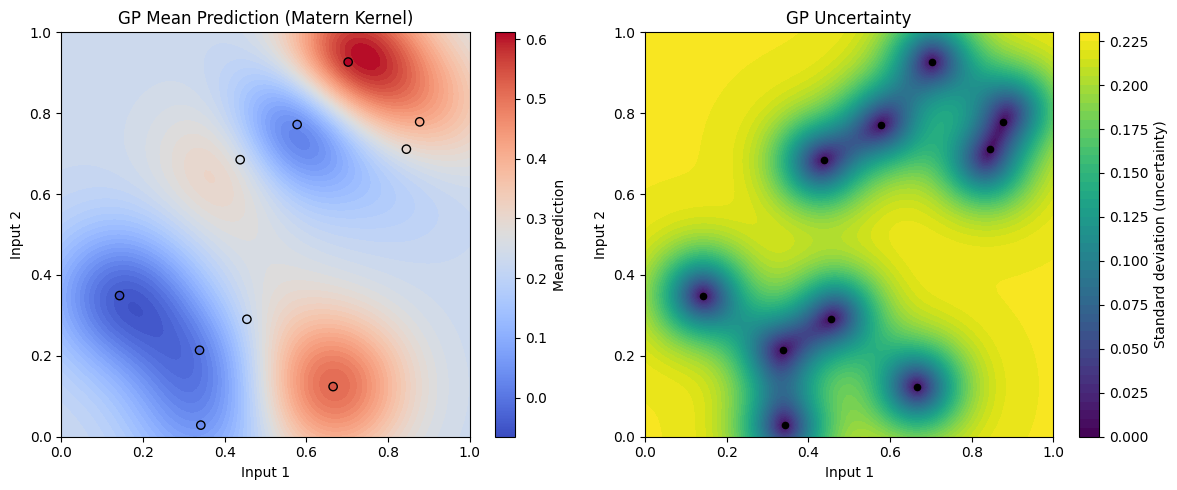

In [16]:
kernel = RBF(length_scale=0.2, length_scale_bounds=(1e-10,1)) + WhiteKernel(noise_level=1e-9, noise_level_bounds=(1e-12, 1e-3))
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=20,
    alpha=1e-8, #modelling noise     
    normalize_y=True,
    random_state=42
)
gp.fit(f2_inputs, f2_outputs)

x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)
X1, X2 = np.meshgrid(x1, x2)
X_grid = np.column_stack([X1.ravel(), X2.ravel()])

y_mean, y_std = gp.predict(X_grid, return_std=True)
Y_mean = y_mean.reshape(X1.shape)
Y_std = y_std.reshape(X1.shape)

# Plot mean
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.contourf(X1, X2, Y_mean, cmap='coolwarm', levels=50)
plt.scatter(f2_inputs[:,0], f2_inputs[:,1], c=f2_outputs, cmap='coolwarm', edgecolor='k')
plt.colorbar(label='Mean prediction')
plt.title("GP Mean Prediction (Matern Kernel)")
plt.xlabel("Input 1")
plt.ylabel("Input 2")

# Plot uncertainty
plt.subplot(1,2,2)
plt.contourf(X1, X2, Y_std, cmap='viridis', levels=50)
plt.colorbar(label='Standard deviation (uncertainty)')
plt.scatter(f2_inputs[:,0], f2_inputs[:,1], c='k', s=20)
plt.title("GP Uncertainty")
plt.xlabel("Input 1")
plt.ylabel("Input 2")

plt.tight_layout()
plt.show()

Let's use a UCB acquisition function, with a choice of k = 2.5.

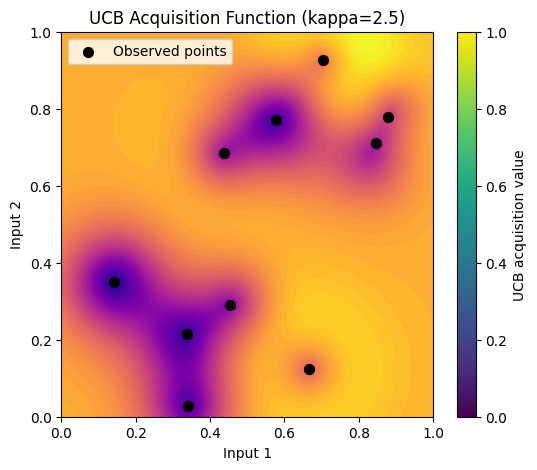

In [17]:
kappa = 2.5
UCB = Y_mean + kappa * Y_std  # shape = (grid_size, grid_size)

plt.figure(figsize=(6,5))
plt.contourf(X1, X2, UCB, cmap='plasma', levels=50)
plt.scatter(f2_inputs[:,0], f2_inputs[:,1], c='k', s=50, label='Observed points')
plt.colorbar(label='UCB acquisition value')
plt.title(f"UCB Acquisition Function (kappa={kappa})")
plt.xlabel("Input 1")
plt.ylabel("Input 2")
plt.legend()
plt.show()

In [18]:
max_idx = np.argmax(UCB)  # index of the maximum UCB
next_point = X_grid[max_idx]  # coordinates in input space

print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Inputs producing current best: {f2_inputs[np.argmax(f2_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

Current best: 0.6112
Inputs producing current best: [0.70263656 0.9265642 ]
Next point to sample based on UCB: [0.81818182 0.97979798]
0.818182-0.979798


Submission for week 1: 0.818182-0.979798


### Week 2

In [19]:
#Load points to inputs and outputs from previous week
function = 2
week = 1 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f2_inputs = np.vstack([f2_inputs, row['provided_input'].values[0]])
f2_outputs = np.append(f2_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")

Submission from last week improved something? False
Current best: 0.6112
Last week's results: 0.1117


In [20]:
print(f"Correlation between inputs: {np.corrcoef(f2_inputs, rowvar=False)}")

print('Means:', f2_inputs.mean(axis=0))
print('Stds:', f2_inputs.std(axis=0))
print('Mins:', f2_inputs.min(axis=0))
print('Maxs:', f2_inputs.max(axis=0))
print('Std/Mean Ratios:', f2_inputs.std(axis=0) / (f2_inputs.mean(axis=0) + 1e-12))

Correlation between inputs: [[1.         0.64729646]
 [0.64729646 1.        ]]
Means: [0.56393704 0.53264507]
Stds: [0.22911406 0.32234258]
Mins: [0.14269907 0.02869772]
Maxs: [0.87779099 0.979798  ]
Std/Mean Ratios: [0.40627596 0.60517331]


Let's try again a similar Gaussian process and plot the results with the new datapoint in hand.

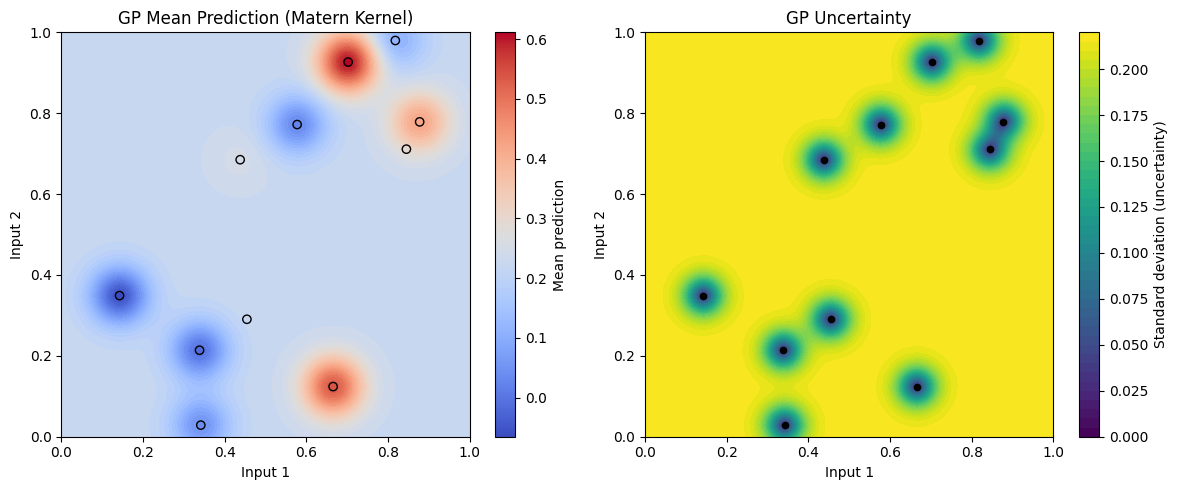

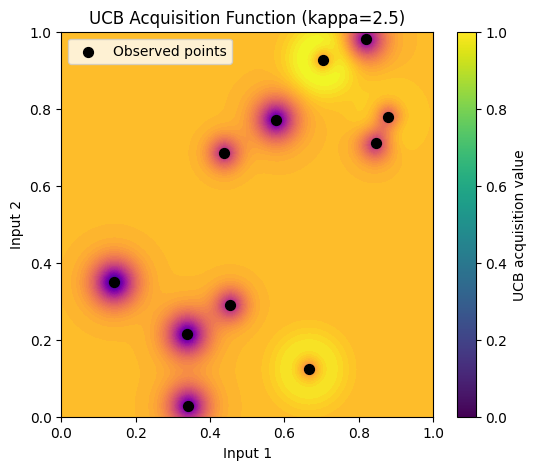

In [21]:
kernel = RBF(length_scale=0.2, length_scale_bounds=(1e-10,1)) + WhiteKernel(noise_level=1e-9, noise_level_bounds=(1e-12, 1e-3))
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=20,
    alpha=1e-8, #modelling noise     
    normalize_y=True,
    random_state=42
)
gp.fit(f2_inputs, f2_outputs)

x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)
X1, X2 = np.meshgrid(x1, x2)
X_grid = np.column_stack([X1.ravel(), X2.ravel()])

y_mean, y_std = gp.predict(X_grid, return_std=True)
Y_mean = y_mean.reshape(X1.shape)
Y_std = y_std.reshape(X1.shape)

# Plot mean
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.contourf(X1, X2, Y_mean, cmap='coolwarm', levels=50)
plt.scatter(f2_inputs[:,0], f2_inputs[:,1], c=f2_outputs, cmap='coolwarm', edgecolor='k')
plt.colorbar(label='Mean prediction')
plt.title("GP Mean Prediction (Matern Kernel)")
plt.xlabel("Input 1")
plt.ylabel("Input 2")

# Plot uncertainty
plt.subplot(1,2,2)
plt.contourf(X1, X2, Y_std, cmap='viridis', levels=50)
plt.colorbar(label='Standard deviation (uncertainty)')
plt.scatter(f2_inputs[:,0], f2_inputs[:,1], c='k', s=20)
plt.title("GP Uncertainty")
plt.xlabel("Input 1")
plt.ylabel("Input 2")

plt.tight_layout()
plt.show()

kappa = 2.5
UCB = Y_mean + kappa * Y_std  # shape = (grid_size, grid_size)

plt.figure(figsize=(6,5))
plt.contourf(X1, X2, UCB, cmap='plasma', levels=50)
plt.scatter(f2_inputs[:,0], f2_inputs[:,1], c='k', s=50, label='Observed points')
plt.colorbar(label='UCB acquisition value')
plt.title(f"UCB Acquisition Function (kappa={kappa})")
plt.xlabel("Input 1")
plt.ylabel("Input 2")
plt.legend()
plt.show()

In [22]:
max_idx = np.argmax(UCB)  # index of the maximum UCB
next_point = X_grid[max_idx]  # coordinates in input space

print(f"Inputs producing current best: {f2_inputs[np.argmax(f2_outputs)]}")
print("Next point to sample based on UCB:", next_point)

Inputs producing current best: [0.70263656 0.9265642 ]
Next point to sample based on UCB: [0.65656566 0.94949495]


The acquisition function is basically suggesting to sample around already known points that are close to the maximum. As we are still on week 2, it is worth to use exploration before exploiting the known areas, especially since we are told that it is easy to get stuck at a local minimum.

Let's try a different surrogate function with a penalized UCB for getting close to the borders.

1.05**2 * Matern(length_scale=[0.0516, 1.62], nu=2.5)
(10000, 2)


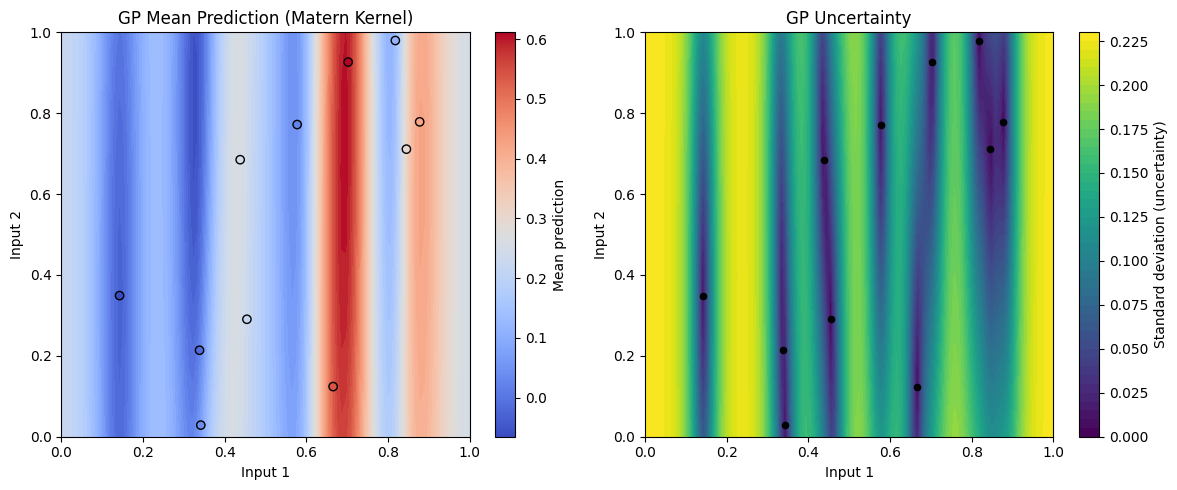

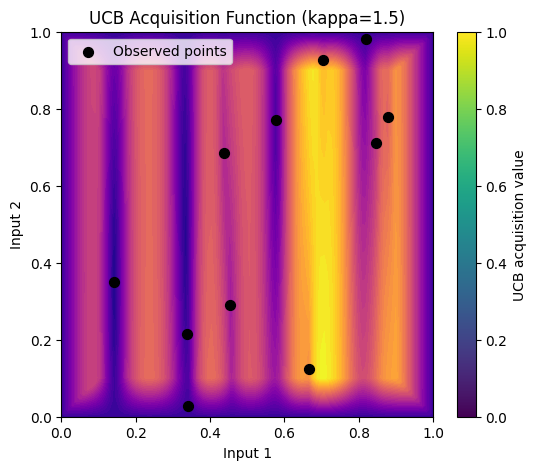

1.05**2 * Matern(length_scale=[0.0516, 1.62], nu=2.5)


In [23]:
kernel = C(1.0, (1e-2, 10.0)) * Matern(length_scale=[1.0, 1.0], length_scale_bounds=(0.01, 10.0), nu=2.5)
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=20,
    alpha=1e-8, #modelling noise     
    normalize_y=True,
    random_state=42
)
gp.fit(f2_inputs, f2_outputs)

print(gp.kernel_)

x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)
X1, X2 = np.meshgrid(x1, x2)
X_grid = np.column_stack([X1.ravel(), X2.ravel()])

print(X_grid.shape)

y_mean, y_std = gp.predict(X_grid, return_std=True)
Y_mean = y_mean.reshape(X1.shape)
Y_std = y_std.reshape(X1.shape)

# Plot mean
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.contourf(X1, X2, Y_mean, cmap='coolwarm', levels=50)
plt.scatter(f2_inputs[:,0], f2_inputs[:,1], c=f2_outputs, cmap='coolwarm', edgecolor='k')
plt.colorbar(label='Mean prediction')
plt.title("GP Mean Prediction (Matern Kernel)")
plt.xlabel("Input 1")
plt.ylabel("Input 2")

# Plot uncertainty
plt.subplot(1,2,2)
plt.contourf(X1, X2, Y_std, cmap='viridis', levels=50)
plt.colorbar(label='Standard deviation (uncertainty)')
plt.scatter(f2_inputs[:,0], f2_inputs[:,1], c='k', s=20)
plt.title("GP Uncertainty")
plt.xlabel("Input 1")
plt.ylabel("Input 2")

plt.tight_layout()
plt.show()

kappa = 1.5
UCB = Y_mean + kappa * Y_std  # shape = (grid_size, grid_size)


# Let's add a penalty for getting close to the borders
# Calculate distance to nearest boundary for each dimension (0 and 1 here)
min_boundary_distance = np.minimum(np.min(X_grid, axis=1), np.min(1 - X_grid, axis=1))

# Penalty factor: linearly scale with distance from boundary (0 at boundary, 1 at distance >= penalty_radius)
penalty_radius = 0.1
penalty_factor = np.clip(min_boundary_distance / penalty_radius, 0, 1)

# Apply penalty
UCB = UCB.reshape(100, 100)
penalty_factor = penalty_factor.reshape(100, 100)
UCB_penalized = UCB * penalty_factor

plt.figure(figsize=(6,5))
plt.contourf(X1, X2, UCB_penalized, cmap='plasma', levels=50)
plt.scatter(f2_inputs[:,0], f2_inputs[:,1], c='k', s=50, label='Observed points')
plt.colorbar(label='UCB acquisition value')
plt.title(f"UCB Acquisition Function (kappa={kappa})")
plt.xlabel("Input 1")
plt.ylabel("Input 2")
plt.legend()
plt.show()

print(gp.kernel_)


In [24]:
max_idx = np.argmax(UCB_penalized)  # index of the maximum UCB
next_point = X_grid[max_idx]  # coordinates in input space

print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Inputs producing current best: {f2_inputs[np.argmax(f2_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

Current best: 0.6112
Inputs producing current best: [0.70263656 0.9265642 ]
Next point to sample based on UCB: [0.70707071 0.1010101 ]
0.707071-0.101010


Submission for week 2: 0.707071-0.101010

### Week 3

In [25]:
#Load points to inputs and outputs from previous week
function = 2
week = 2 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f2_inputs = np.vstack([f2_inputs, row['provided_input'].values[0]])
f2_outputs = np.append(f2_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f2_inputs.shape}")
print(f"Inputs range: [{np.min(f2_inputs):.4f}, {np.max(f2_inputs):.4f}]")
print(f"Performance range: [{np.min(f2_outputs):.4e}, {np.max(f2_outputs):.4e}]")

Submission from last week improved something? False
Current best: 0.6112
Last week's results: 0.5756
--
Inputs shape: (12, 2)
Inputs range: [0.0287, 0.9798]
Performance range: [-6.5624e-02, 6.1121e-01]


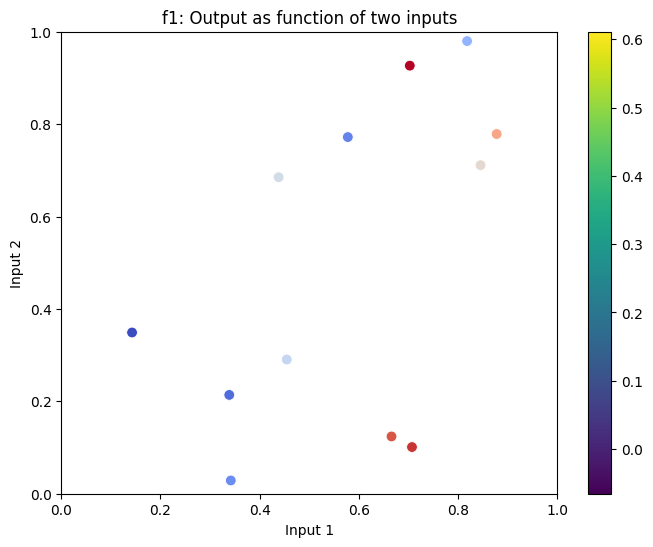

Evaluations: 12
Inputs shape: (12, 2)
Inputs range: [0.0287, 0.9798]
Performance range: [-0.0656, 0.6112]
Current best: 0.6112
Inputs producing current best: [0.70263656 0.9265642 ]


In [26]:
x1 = f2_inputs[:, 0]
x2 = f2_inputs[:, 1]
y = f2_outputs

# Put data into a DataFrame
df = pd.DataFrame({
    "x1": x1,
    "x2": x2,
    "y": y
})

# Scatter plot with color encoding the output
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="x1", y="x2", hue="y", palette="coolwarm", s=60, legend=False)
plt.title("f1: Output as function of two inputs")
plt.xlabel("Input 1")
plt.ylabel("Input 2")
plt.xlim(0, 1)
plt.ylim(0, 1)
norm = plt.Normalize(vmin=y.min(), vmax=y.max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
plt.colorbar(sm, ax=plt.gca())
plt.show()


print(f"Evaluations: {len(f2_inputs)}")
print(f"Inputs shape: {f2_inputs.shape}")
print(f"Inputs range: [{np.min(f2_inputs):.4f}, {np.max(f2_inputs):.4f}]")
print(f"Performance range: [{np.min(f2_outputs):.4f}, {np.max(f2_outputs):.4f}]")
print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Inputs producing current best: {f2_inputs[np.argmax(f2_outputs)]}")

Even though the performance did not improve this week, we found potential for another local maximum.

In [27]:
# Define kernel: Matern with nu=2.5 for sharp peaks
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[0.2, 0.2], nu=2.5)

# Instantiate GP with small noise level
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, normalize_y=True)

# Fit the GP model
gp.fit(f2_inputs, f2_outputs)
print(gp.kernel_)


# Function to optimize acquisition: Expected Improvement
def acquisitionf(x):
    x = np.array(x).reshape(1, -1)
    mean, std = gp.predict(x, return_std=True)
    # Current best observation
    best_y = np.max(f1_outputs)
    # Calculate EI
    from scipy.stats import norm
    z = (mean - best_y) / (std + 1e-9)
    ei = (mean - best_y) * norm.cdf(z) + std * norm.pdf(z)
    return -ei.item()  

# Robust acquisition maximization via multi-start local optimization
bounds = [(0, 1), (0, 1)]
num_restarts = 1500 # I have incremented this until the estimation did no longer move (fixed random seed)
results = []
np.random.seed(42)

for _ in range(num_restarts):
    x0 = np.random.uniform(0, 1, 2)
    res = minimize(acquisitionf, x0, bounds=bounds, method='L-BFGS-B')
    results.append(res)

print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Inputs producing current best: {f2_inputs[np.argmax(f2_outputs)]}")

# Select best solution from restarts
next_point = min(results, key=lambda r: r.fun).x
print("Next sample point (local optimizer):", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

1.01**2 * Matern(length_scale=[0.0523, 2.56], nu=2.5)
Current best: 0.6112
Inputs producing current best: [0.70263656 0.9265642 ]
Next sample point (local optimizer): [0.69360469 0.80580801]
0.693605-0.805808


Submission for week 3: 0.693605-0.805808

Which is along the vertical line that we found to seem to contain maxima.

## Function 3

This function is a function with a 1D output and a 3D input. 

This is the description of the function: you’re working on a drug discovery project, testing combinations of three compounds to create a new medicine.

Each experiment is stored in initial_inputs.npy as a 3D array, where each row lists the amounts of the three compounds used. After each experiment, you record the number of adverse reactions, stored in initial_outputs.npy as a 1D array.

Your goal is to minimise side effects; in this competition, it is framed as maximisation by optimising a transformed output (e.g. the negative of side effects). 

### Week 1

Let's observe the data.

In [28]:
#print(f3_inputs)
#print(f3_outputs)

print(f"Evaluations: {len(f3_inputs)}")
print(f"Inputs shape: {f3_inputs.shape}")
print(f"Inputs range: [{np.min(f3_inputs):.4f}, {np.max(f3_inputs):.4f}]")
print(f"Performance range: [{np.min(f3_outputs):.4f}, {np.max(f3_outputs):.4f}]")
print(f"Current best: {np.max(f3_outputs):.4f}")
print(f"Inputs producing current best: {f3_inputs[np.argmax(f3_outputs)]}")


Evaluations: 15
Inputs shape: (15, 3)
Inputs range: [0.0468, 0.9909]
Performance range: [-0.3989, -0.0348]
Current best: -0.0348
Inputs producing current best: [0.49258141 0.61159319 0.34017639]


And even attempt to plot it.

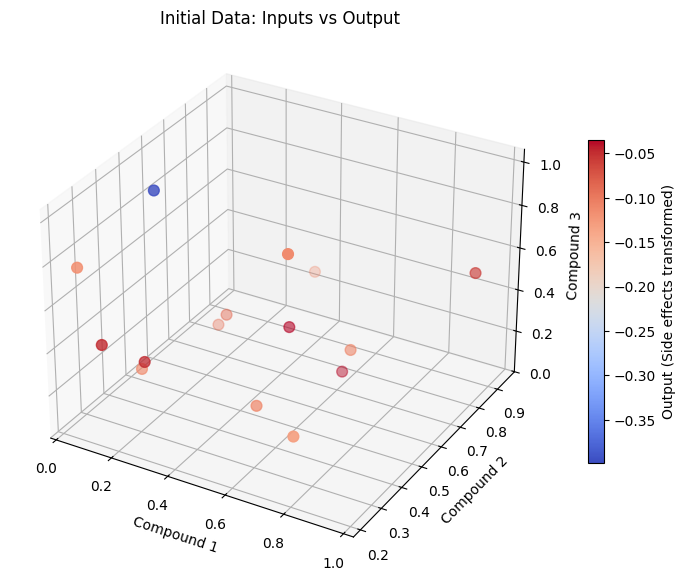

In [29]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(f3_inputs[:,0], f3_inputs[:,1], f3_inputs[:,2], 
                c=f3_outputs, cmap='coolwarm', s=60)

ax.set_xlabel("Compound 1")
ax.set_ylabel("Compound 2")
ax.set_zlabel("Compound 3")
ax.set_title("Initial Data: Inputs vs Output")
cbar = fig.colorbar(sc, ax=ax, shrink=0.6)
cbar.set_label("Output (Side effects transformed)")
plt.show()

In [30]:
# Let's follow a similar approach as with the others with a Matern and WhiteKerel

kernel = Matern(length_scale=[0.1, 0.1, 0.1], length_scale_bounds=(0.01, 1.0), nu=1.5) \
         + WhiteKernel(noise_level=1e-6)
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=10)
gp.fit(f3_inputs, f3_outputs)

h:\Projects\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
h:\Projects\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
h:\Projects\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


,kernel,Matern(length...e_level=1e-06)
,alpha,1e-06
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,10
,normalize_y,True
,copy_X_train,True
,n_targets,None
,random_state,None
,kernel__k1,"Matern(length... 0.1], nu=1.5)"
,kernel__k2,WhiteKernel(noise_level=1e-06)
,kernel__k1__length_scale,"[0.1, 0.1, ...]"


Getting these warnings:
* ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
* ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
* ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.

In [31]:
# Trying new hyperparameters, with wider length scale bounds, and introducing noise_level_bounds. amd more restarts optimizers, a constant kernel and wider bounds.

# Let's follow a similar approach as with the others with a Matern and WhiteKerel and a Constant Kernel (because I was getting many "close to bounds" messages)

kernel = C(1.0, (1e-5, 1e5)) * Matern(length_scale=[1.0, 1.0, 1.0], length_scale_bounds=(1e-5, 1e8), nu=2.5) \
         + WhiteKernel(noise_level=1e-8, noise_level_bounds=(1e-10, 1e0))
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=20, random_state=42)
gp.fit(f3_inputs, f3_outputs)

# And calculate over the whole cube

x1 = np.linspace(0, 1, 30)
x2 = np.linspace(0, 1, 30)
x3 = np.linspace(0, 1, 30)
X1, X2, X3 = np.meshgrid(x1, x2, x3)
X_candidate = np.column_stack([X1.ravel(), X2.ravel(), X3.ravel()])
y_mean, y_std = gp.predict(X_candidate, return_std=True)

# We will use Probability of improvement (PI) as an acquisition function with a penalty for being close to the boundary (was getting 1 1 0)
y_max = np.max(f3_outputs)
eta = 0.01
z = (y_mean - y_max - eta) / (y_std + 1e-12)
pi = stats.norm.cdf(z)
boundary_distances = np.minimum(X_candidate, 1 - X_candidate)
min_boundary_distance = np.min(boundary_distances, axis=1)
boundary_penalty = np.clip(min_boundary_distance / 0.1, 0, 1)
        
acquisition_function = pi * boundary_penalty

best_idx = np.argmax(acquisition_function)
next_point = X_candidate[best_idx]

print(f"Current best: {np.max(f3_outputs):.4f}")
print(f"Inputs producing current best: {f3_inputs[np.argmax(f3_outputs)]}")
print("Next point to sample based on PI:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

Current best: -0.0348
Inputs producing current best: [0.49258141 0.61159319 0.34017639]
Next point to sample based on PI: [0.17241379 0.20689655 0.20689655]
0.172414-0.206897-0.206897


Submission for week 1: 0.172414-0.206897-0.206897

### Week 2

In [32]:
#Load points to inputs and outputs from previous week
function = 3
week = 1 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f3_inputs = np.vstack([f3_inputs, row['provided_input'].values[0]])
f3_outputs = np.append(f3_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f3_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")

Submission from last week improved something? False
Current best: -0.0348
Last week's results: -0.1476


In [33]:
print(f"Correlation between inputs: {np.corrcoef(f3_inputs, rowvar=False)}")

print('Means:', f3_inputs.mean(axis=0))
print('Stds:', f3_inputs.std(axis=0))
print('Mins:', f3_inputs.min(axis=0))
print('Maxs:', f3_inputs.max(axis=0))
print('Std/Mean Ratios:', f3_inputs.std(axis=0) / (f3_inputs.mean(axis=0) + 1e-12))

Correlation between inputs: [[ 1.          0.43437673 -0.08996019]
 [ 0.43437673  1.         -0.22739406]
 [-0.08996019 -0.22739406  1.        ]]
Means: [0.39424239 0.49825298 0.3905444 ]
Stds: [0.26357423 0.23052493 0.26998681]
Mins: [0.04680895 0.206897   0.06608864]
Maxs: [0.96599485 0.94135983 0.99088187]
Std/Mean Ratios: [0.66855884 0.46266644 0.6913089 ]


Let us try the same strategy again but with a UCB function

In [34]:
kernel = C(1.0, (1e-5, 1e5)) * Matern(length_scale=[1.0, 1.0, 1.0], length_scale_bounds=(1e-5, 1e8), nu=2.5) \
         + WhiteKernel(noise_level=1e-8, noise_level_bounds=(1e-10, 1e0))
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=20, random_state=42)
gp.fit(f3_inputs, f3_outputs)


print(gp.kernel_)
#print(f3_inputs)

# And calculate over the whole cube

x1 = np.linspace(0, 1, 30)
x2 = np.linspace(0, 1, 30)
x3 = np.linspace(0, 1, 30)
X1, X2, X3 = np.meshgrid(x1, x2, x3)
X_candidate = np.column_stack([X1.ravel(), X2.ravel(), X3.ravel()])
y_mean, y_std = gp.predict(X_candidate, return_std=True)

# We will use Probability of improvement (PI) as an acquisition function with a penalty for being close to the boundary (was getting 1 1 0)
y_max = np.max(f3_outputs)
eta = 0.01
z = (y_mean - y_max - eta) / (y_std + 1e-12)
pi = stats.norm.cdf(z)
boundary_distances = np.minimum(X_candidate, 1 - X_candidate)
min_boundary_distance = np.min(boundary_distances, axis=1)
boundary_penalty = np.clip(min_boundary_distance / 0.1, 0, 1)
        
acquisition_function = pi * boundary_penalty

best_idx = np.argmax(acquisition_function)
next_point_pi = X_candidate[best_idx]

print(f"Current best: {np.max(f3_outputs):.4f}")
print(f"Inputs producing current best: {f3_inputs[np.argmax(f3_outputs)]}")
print("Next point to sample based on PI:", next_point_pi)

kappa = 0.5
UCB = Y_mean + kappa * Y_std  # shape = (grid_size, grid_size)
max_idx = np.argmax(UCB)  # index of the maximum UCB
next_point_ucb = X_candidate[max_idx]  # coordinates in input space
print("Next point to sample based on UCB:", next_point_ucb)


print("-".join(f"{x:.6f}" for x in next_point_ucb.flatten()))

1.06**2 * Matern(length_scale=[0.00375, 1.59e+07, 2.7e+04], nu=2.5) + WhiteKernel(noise_level=0.00456)
Current best: -0.0348
Inputs producing current best: [0.49258141 0.61159319 0.34017639]
Next point to sample based on PI: [0.13793103 0.10344828 0.4137931 ]
Next point to sample based on UCB: [0.86206897 0.13793103 0.65517241]
0.862069-0.137931-0.655172


Submission for week 2: 0.862069-0.137931-0.655172

### Week 3

In [35]:
#Load points to inputs and outputs from previous week
function = 3
week = 2 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f3_inputs = np.vstack([f3_inputs, row['provided_input'].values[0]])
f3_outputs = np.append(f3_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f3_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f3_inputs.shape}")
print(f"Inputs range: [{np.min(f3_inputs):.4f}, {np.max(f3_inputs):.4f}]")
print(f"Performance range: [{np.min(f3_outputs):.4f}, {np.max(f3_outputs):.4f}]")

Submission from last week improved something? False
Current best: -0.0348
Last week's results: -0.1406
--
Inputs shape: (17, 3)
Inputs range: [0.0468, 0.9909]
Performance range: [-0.3989, -0.0348]


For this function I have been unable to make any improvement yet. This week I will try the same approach as for functions 1 and 2 with an EI acquisition function.

In [36]:
# Define kernel: Matern with nu=2.5 for sharp peaks
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[0.2]*3, nu=2.5)

# Instantiate GP with small noise level
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, normalize_y=True)

# Fit the GP model
gp.fit(f3_inputs, f3_outputs)
print(gp.kernel_)


# Function to optimize acquisition: Expected Improvement
def acquisitionf(x):
    x = np.array(x).reshape(1, -1)
    mean, std = gp.predict(x, return_std=True)
    # Current best observation
    best_y = np.max(f1_outputs)
    # Calculate EI
    from scipy.stats import norm
    z = (mean - best_y) / (std + 1e-9)
    ei = (mean - best_y) * norm.cdf(z) + std * norm.pdf(z)
    return -ei.item()  

# Robust acquisition maximization via multi-start local optimization
bounds = [(0, 1), (0, 1), (0, 1)]
num_restarts = 1500 # I have incremented this until the estimation did no longer move (fixed random seed)
results = []
np.random.seed(42)

for _ in range(num_restarts):
    x0 = np.random.uniform(0, 1, 3)
    res = minimize(acquisitionf, x0, bounds=bounds, method='L-BFGS-B')
    results.append(res)

print(f"Current best: {np.max(f3_outputs):.4f}")
print(f"Inputs producing current best: {f2_inputs[np.argmax(f3_outputs)]}")

# Select best solution from restarts
next_point = min(results, key=lambda r: r.fun).x
print("Next sample point (local optimizer):", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

1.19**2 * Matern(length_scale=[1e+05, 2.5e+04, 0.0299], nu=2.5)


h:\Projects\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Current best: -0.0348
Inputs producing current best: [0.84527543 0.71112027]
Next sample point (local optimizer): [0.50746773 0.00638587 0.30526791]
0.507468-0.006386-0.305268


Submission for week 3: 0.507468-0.006386-0.305268

## Function 4

This function is a function with a 1D output and a 4D input. 

This is the description of the function: Address the challenge of optimally placing products across warehouses for a business with high online sales, where accurate calculations are costly and only feasible biweekly. To speed up decision-making, an ML model approximates these results within hours. The model has four hyperparameters to tune, and its output reflects the difference from the expensive baseline. Because the system is dynamic and full of local optima, it requires careful tuning and robust validation to find reliable, near-optimal solutions. 

### Week 1

It is no longer viable to plot anything, so let's just look at the data:

In [37]:
print(f"Evaluations: {len(f4_inputs)}")
print(f"Inputs shape: {f4_inputs.shape}")
print(f"Inputs range: [{np.min(f4_inputs):.4f}, {np.max(f4_inputs):.4f}]")
print(f"Performance range: [{np.min(f4_outputs):.4f}, {np.max(f4_outputs):.4f}]")
print(f"Current best: {np.max(f4_outputs):.4f}")
print(f"Inputs producing current best: {f4_inputs[np.argmax(f4_outputs)]}")


Evaluations: 30
Inputs shape: (30, 4)
Inputs range: [0.0063, 0.9995]
Performance range: [-32.6257, -4.0255]
Current best: -4.0255
Inputs producing current best: [0.57776561 0.42877174 0.42582587 0.24900741]


In [38]:
kernel = (C(1.0, (1e-3, 1e3)) * Matern(length_scale=[2.0]*4, length_scale_bounds=(0.1, 1000.0), nu=2.5) + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-15, 1e-1)))
gp = GaussianProcessRegressor(
        kernel=kernel,
        alpha=1e-6,
        normalize_y=True,
        n_restarts_optimizer=30,
        random_state=42
    )
gp.fit(f4_inputs, f4_outputs)

x1 = np.linspace(0, 1, 30)
x2 = np.linspace(0, 1, 30)
x3 = np.linspace(0, 1, 30)
x4 = np.linspace(0, 1, 30)
X1, X2, X3, X4 = np.meshgrid(x1, x2, x3, x4)
X_candidate = np.column_stack([X1.ravel(), X2.ravel(), X3.ravel(), X4.ravel()])

# Expected improvement
mu, sigma = gp.predict(X_candidate, return_std=True)
best = np.max(f4_outputs)
xi = 0.01
z = (mu - best - xi) / (sigma + 1e-12)
ei = (mu - best - xi) * stats.norm.cdf(z) + sigma * stats.norm.pdf(z)
ei

best_idx = np.argmax(ei)
next_point = X_candidate[best_idx]

print(f"Current best: {np.max(f4_outputs):.4f}")
print(f"Inputs producing current best: {f4_inputs[np.argmax(f4_outputs)]}")
print("Next point to sample based on PI:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

Current best: -4.0255
Inputs producing current best: [0.57776561 0.42877174 0.42582587 0.24900741]
Next point to sample based on PI: [0.44827586 0.4137931  0.37931034 0.37931034]
0.448276-0.413793-0.379310-0.379310


Submission for week 1: 0.448276-0.413793-0.379310-0.379310

### Week 2

In [39]:
#Load points to inputs and outputs from previous week
function = 4
week = 1 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f4_inputs = np.vstack([f4_inputs, row['provided_input'].values[0]])
f4_outputs = np.append(f4_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f4_outputs):.4f}")
print(f"Previous best: {results_df[(results_df['week'] == week-1) & (results_df['function'] == function)]['known_best'].values[0]:.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")

Submission from last week improved something? True
Current best: -0.0512
Previous best: -4.0255
Last week's results: -0.0512


This yielded a very good improvement. Let's replicate the method again this week, including the EI function.

In [40]:
kernel = (C(1.0, (1e-3, 1e3)) * Matern(length_scale=[2.0]*4, length_scale_bounds=(0.1, 1000.0), nu=2.5) + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-15, 1e-1)))
gp = GaussianProcessRegressor(
        kernel=kernel,
        alpha=1e-6,
        normalize_y=True,
        n_restarts_optimizer=30,
        random_state=42
    )
gp.fit(f4_inputs, f4_outputs)
print(gp.kernel_)

x1 = np.linspace(0, 1, 30)
x2 = np.linspace(0, 1, 30)
x3 = np.linspace(0, 1, 30)
x4 = np.linspace(0, 1, 30)
X1, X2, X3, X4 = np.meshgrid(x1, x2, x3, x4)
X_candidate = np.column_stack([X1.ravel(), X2.ravel(), X3.ravel(), X4.ravel()])

# Expected improvement
mu, sigma = gp.predict(X_candidate, return_std=True)
best = np.max(f4_outputs)
xi = 0.01
z = (mu - best - xi) / (sigma + 1e-12)
ei = (mu - best - xi) * stats.norm.cdf(z) + sigma * stats.norm.pdf(z)

best_idx = np.argmax(ei)
next_point = X_candidate[best_idx]

print(f"Current best: {np.max(f4_outputs):.4f}")
print(f"Inputs producing current best: {f4_inputs[np.argmax(f4_outputs)]}")
print("Next point to sample based on PI:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

3.18**2 * Matern(length_scale=[1.56, 1.46, 1.58, 1.43], nu=2.5) + WhiteKernel(noise_level=7.76e-15)
Current best: -0.0512
Inputs producing current best: [0.448276 0.413793 0.37931  0.37931 ]
Next point to sample based on PI: [0.4137931  0.4137931  0.34482759 0.4137931 ]
0.413793-0.413793-0.344828-0.413793


The kernel is very balanced in terms of length scale for each dimension.

Submission for week 2: 0.413793-0.413793-0.344828-0.413793

### Week 3

In [41]:
#Load points to inputs and outputs from previous week
function = 4
week = 2 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f4_inputs = np.vstack([f4_inputs, row['provided_input'].values[0]])
f4_outputs = np.append(f4_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f4_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f4_inputs.shape}")
print(f"Inputs range: [{np.min(f4_inputs):.4f}, {np.max(f4_inputs):.4f}]")
print(f"Performance range: [{np.min(f4_outputs):.4f}, {np.max(f4_outputs):.4f}]")

Submission from last week improved something? True
Current best: 0.6231
Last week's results: 0.6231
--
Inputs shape: (32, 4)
Inputs range: [0.0063, 0.9995]
Performance range: [-32.6257, 0.6231]


While this is the second improvement in a row, this function 4 has been sampled around the same point for two weeks in a row already.  This is encouraging exploitation. This week, for a change, I am using a UCB kernel encouraging exploration to see if I can find another local minimum.

In [ ]:
kernel = (C(1.0, (1e-3, 1e3)) * Matern(length_scale=[2.0]*4, length_scale_bounds=(0.1, 1000.0), nu=2.5) + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-15, 1e-1)))
gp = GaussianProcessRegressor(
        kernel=kernel,
        alpha=1e-6,
        normalize_y=True,
        n_restarts_optimizer=30,
        random_state=42
    )
gp.fit(f4_inputs, f4_outputs)
print(gp.kernel_)

def negative_ucb(x, gp, kappa):
    mu, sigma = gp.predict(x.reshape(1, -1), return_std=True)
    return -(mu[0] + kappa * sigma[0])

bounds = [(0, 1) for _ in range(4)]
num_restarts = 50 
results = []
np.random.seed(42)

for _ in range(num_restarts):
    x0 = np.random.uniform(0, 1, 4)
    #choosing kappa 3.7 to encourage exploration
    result = minimize(negative_ucb, x0=np.random.uniform(0, 1, 4), 
                 args=(gp, 3.7), bounds=bounds, method='L-BFGS-B')
    if result.success:
        results.append(result)
    
# Select best solution from restarts
next_point = min(results, key=lambda r: r.fun).x

print(f"Current best: {np.max(f4_outputs):.4f}")
print(f"Inputs producing current best: {f4_inputs[np.argmax(f4_outputs)]}")
print("Next sample point (local optimizer):", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))


3.03**2 * Matern(length_scale=[1.57, 1.38, 1.64, 1.42], nu=2.5) + WhiteKernel(noise_level=0.000247)
Next sample point (local optimizer): [0.47186077 0.44620076 0.13676784 0.43451071]
0.471861-0.446201-0.136768-0.434511


Submission for week 3: 0.471861-0.446201-0.136768-0.434511

This is still exploiting this area. Next week I will just sample the point furthest from all known samples.

### Week 4

In [43]:
# Place holder for stats code

This week the goal is just to sample the point that is further away from all known points to try and find another local minimum as the function descriptions describes it as having many and my strategy so far has been on exploitation.

## Function 5

This function is a function with a 1D output and a 4D input. 

This is the description of the function: You’re tasked with optimising a four-variable black-box function that represents the yield of a chemical process in a factory. The function is typically unimodal, with a single peak where yield is maximised. 

Your goal is to find the optimal combination of chemical inputs that delivers the highest possible yield, using systematic exploration and optimisation methods.

### Week 1

In [44]:
print(f"Evaluations: {len(f5_inputs)}")
print(f"Inputs shape: {f5_inputs.shape}")
print(f"Inputs range: [{np.min(f5_inputs):.4f}, {np.max(f5_inputs):.4f}]")
print(f"Performance range: [{np.min(f5_outputs):.4f}, {np.max(f5_outputs):.4f}]")
print(f"Current best: {np.max(f5_outputs):.4f}")
print(f"Inputs producing current best: {f5_inputs[np.argmax(f5_outputs)]}")

Evaluations: 20
Inputs shape: (20, 4)
Inputs range: [0.0382, 0.9576]
Performance range: [0.1129, 1088.8596]
Current best: 1088.8596
Inputs producing current best: [0.22418902 0.84648049 0.87948418 0.87851568]


In [45]:
# Function is unimodal with a single peak, so I am choosing an RBF kernel
kernel = RBF(length_scale=[1.0] * 4, length_scale_bounds=(0.05, 15000.0)) 
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=15,
    alpha=1e-6, #modelling noise     
    normalize_y=True,
    random_state=42
)
gp.fit(f5_inputs, f5_outputs)

x1 = np.linspace(0, 1, 30)
x2 = np.linspace(0, 1, 30)
x3 = np.linspace(0, 1, 30)
x4 = np.linspace(0, 1, 30)
X1, X2, X3, X4 = np.meshgrid(x1, x2, x3, x4)
X_candidate = np.column_stack([X1.ravel(), X2.ravel(), X3.ravel(), X4.ravel()])

# Expected improvement
y_mean, y_std = gp.predict(X_candidate, return_std=True)

# The fact that the function has a single peak also makes me avoid PI, and a simple UCB should be fine
kappa = 2.0
UCB = y_mean + kappa * y_std 

max_idx = np.argmax(UCB)  # index of the maximum UCB
next_point = X_candidate[max_idx]  # coordinates in input space

print(f"Current best: {np.max(f5_outputs):.4f}")
print(f"Inputs producing current best: {f5_inputs[np.argmax(f5_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

Current best: 1088.8596
Inputs producing current best: [0.22418902 0.84648049 0.87948418 0.87851568]
Next point to sample based on UCB: [0.5862069  0.62068966 1.         0.93103448]
0.586207-0.620690-1.000000-0.931034


Submission for week 1: 0.586207-0.620690-1.000000-0.931034

It is noted that I am one value at one of the bounds, will explore next week.

### Week 2

In [46]:
#Load points to inputs and outputs from previous week
function = 5
week = 1 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f5_inputs = np.vstack([f5_inputs, row['provided_input'].values[0]])
f5_outputs = np.append(f5_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f5_outputs):.4f}")
print(f"Previous best: {results_df[(results_df['week'] == week-1) & (results_df['function'] == function)]['known_best'].values[0]:.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")

Submission from last week improved something? True
Current best: 1687.3801
Previous best: 1088.8596
Last week's results: 1687.3801


This yielded a very good improvement, what this function maximum is is unknown.

Let's replicate again the same method this week

In [47]:
# Function is unimodal with a single peak, so I am choosing an RBF kernel
kernel = RBF(length_scale=[1.0] * 4, length_scale_bounds=(0.05, 15000.0)) 
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=15,
    alpha=1e-6, #modelling noise     
    normalize_y=True,
    random_state=42
)
gp.fit(f5_inputs, f5_outputs)

print(gp.kernel_)

x1 = np.linspace(0, 1, 30)
x2 = np.linspace(0, 1, 30)
x3 = np.linspace(0, 1, 30)
x4 = np.linspace(0, 1, 30)
X1, X2, X3, X4 = np.meshgrid(x1, x2, x3, x4)
X_candidate = np.column_stack([X1.ravel(), X2.ravel(), X3.ravel(), X4.ravel()])

# Expected improvement
y_mean, y_std = gp.predict(X_candidate, return_std=True)

# The fact that the function has a single peak also makes me avoid PI, and a simple UCB should be fine
kappa = 0.5
UCB = y_mean + kappa * y_std 

max_idx = np.argmax(UCB)  # index of the maximum UCB
next_point = X_candidate[max_idx]  # coordinates in input space

print(f"Current best: {np.max(f5_outputs):.4f}")
print(f"Inputs producing current best: {f5_inputs[np.argmax(f5_outputs)]}")
print("Next point to sample based on UCB:", next_point)

RBF(length_scale=[11.3, 5.31, 0.513, 0.209])
Current best: 1687.3801
Inputs producing current best: [0.586207 0.62069  1.       0.931034]
Next point to sample based on UCB: [1. 0. 1. 1.]


This would be encouraging sampling on a corner. While I may try this once, I will first try for this week's submission:
* Reducing the boundaries so that extreme values are not suggested.
* A denser mesh as 4 dimensions is still manageable.
* A penalty for being close to the borders (not linear but harsh around the border)

In [48]:
# If you want to avoid sampling exactly at the edges
x1 = np.linspace(0.05, 0.95, 50)
x2 = np.linspace(0.05, 0.95, 50)
x3 = np.linspace(0.05, 0.95, 50)
x4 = np.linspace(0.05, 0.95, 50)
X1, X2, X3, X4 = np.meshgrid(x1, x2, x3, x4)
X_candidate = np.column_stack([X1.ravel(), X2.ravel(), X3.ravel(), X4.ravel()])

y_mean, y_std = gp.predict(X_candidate, return_std=True)

kappa = 0.5
UCB = y_mean + kappa * y_std
#edge_penalty = 0.5 * ((X_candidate < 0.07) | (X_candidate > 0.93)).sum(axis=1)
#UCB_adjusted = UCB - edge_penalty

# Let's add a penalty for getting close to the borders
# Calculate distance to nearest boundary for each dimension (0 and 1 here)
min_boundary_distance = np.minimum(np.min(X_candidate, axis=1), np.min(1 - X_candidate, axis=1))
min_boundary_distance.shape

# Penalty factor: linearly scale with distance from boundary (0 at boundary, 1 at distance >= penalty_radius)
penalty_radius = 0.1
penalty_factor = np.clip(min_boundary_distance / penalty_radius, 0, 1)

# Apply penalty
UCB_penalized = UCB * penalty_factor

max_idx = np.argmax(UCB_penalized)
next_point_2 = X_candidate[max_idx]

print(f"Current best: {np.max(f5_outputs):.4f}")
print(f"Inputs producing current best: {f5_inputs[np.argmax(f5_outputs)]}")
print("Next point to sample based on UCB:", next_point_2)

Current best: 1687.3801
Inputs producing current best: [0.586207 0.62069  1.       0.931034]
Next point to sample based on UCB: [0.89489796 0.10510204 0.89489796 0.89489796]


Considering this, I will choose to sample the extreme this week and, depending on the result, reevaluate next week.

In [49]:
print("Next point to sample based on UCB:", next_point_2)
print("-".join(f"{x:.6f}" for x in next_point_2.flatten()))

Next point to sample based on UCB: [0.89489796 0.10510204 0.89489796 0.89489796]
0.894898-0.105102-0.894898-0.894898


Submission for week 2: 0.894898-0.105102-0.894898-0.894898

### Week 3

In [50]:
#Load points to inputs and outputs from previous week
function = 5
week = 2 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f5_inputs = np.vstack([f5_inputs, row['provided_input'].values[0]])
f5_outputs = np.append(f5_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f5_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f5_inputs.shape}")
print(f"Inputs range: [{np.min(f5_inputs):.4f}, {np.max(f5_inputs):.4f}]")
print(f"Performance range: [{np.min(f5_outputs):.4f}, {np.max(f5_outputs):.4f}]")

Submission from last week improved something? False
Current best: 1687.3801
Last week's results: 1488.8645
--
Inputs shape: (22, 4)
Inputs range: [0.0382, 1.0000]
Performance range: [0.1129, 1687.3801]


In [ ]:
#Switching to Mattern kernel
 
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[0.2]*4, nu=2.5) \
         + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-8, 1e0))
gp = GaussianProcessRegressor(
        kernel=kernel,
        alpha=1e-6,
        normalize_y=True,
        n_restarts_optimizer=30,
        random_state=42
    )
gp.fit(f4_inputs, f4_outputs)
print(gp.kernel_)

def negative_ucb(x, gp, kappa):
    mu, sigma = gp.predict(x.reshape(1, -1), return_std=True)
    return -(mu[0] + kappa * sigma[0])

bounds = [(0, 1) for _ in range(4)]
num_restarts = 50
results = []
np.random.seed(42)

for _ in range(num_restarts):
    x0 = np.random.uniform(0, 1, 4)
    #choosing kappa 2.7 
    result = minimize(negative_ucb, x0=np.random.uniform(0, 1, 4), 
                 args=(gp, 2.7), bounds=bounds, method='L-BFGS-B')
    if result.success:
        results.append(result)
    
# Select best solution from restarts
next_point = min(results, key=lambda r: r.fun).x

print(f"Current best: {np.max(f5_outputs):.4f}")
print(f"Inputs producing current best: {f5_inputs[np.argmax(f5_outputs)]}")
print("Next sample point (local optimizer):", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

3.03**2 * Matern(length_scale=[1.57, 1.38, 1.64, 1.42], nu=2.5) + WhiteKernel(noise_level=0.000247)
Next sample point (local optimizer): [0.45264012 0.43335377 0.2029193  0.44170423]
0.452640-0.433354-0.202919-0.441704


Submission for week 3: 0.452640-0.433354-0.202919-0.441704

## Function 6

This function is a function with a 1D output and a 5D input. 

This is the description of the function: You’re optimising a cake recipe using a black-box function with five ingredient inputs, for example flour, sugar, eggs, butter and milk. Each recipe is evaluated with a combined score based on flavour, consistency, calories, waste and cost, where each factor contributes negative points as judged by an expert taster. This means the total score is negative by design. 

To frame this as a maximisation problem, your goal is to bring that score as close to zero as possible or, equivalently, to maximise the negative of the total sum.

### Week 1


In [51]:
print(f"Evaluations: {len(f6_inputs)}")
print(f"Inputs shape: {f6_inputs.shape}")
print(f"Inputs range: [{np.min(f6_inputs):.4f}, {np.max(f6_inputs):.4f}]")
print(f"Performance range: [{np.min(f6_outputs):.4f}, {np.max(f6_outputs):.4f}]")
print(f"Current best: {np.max(f6_outputs):.4f}")
print(f"Inputs producing current best: {f6_inputs[np.argmax(f6_outputs)]}")


Evaluations: 20
Inputs shape: (20, 5)
Inputs range: [0.0049, 0.9788]
Performance range: [-2.5712, -0.7143]
Current best: -0.7143
Inputs producing current best: [0.7281861  0.15469257 0.73255167 0.69399651 0.05640131]


In [ ]:
kernel = RBF(length_scale=[1.0] * 5, length_scale_bounds=(0.05, 15000.0)) 
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=15,
    alpha=1e-6, #modelling noise     
    normalize_y=True,
    random_state=42
)
gp.fit(f6_inputs, f6_outputs)

x1 = np.linspace(0, 1, 30)
x2 = np.linspace(0, 1, 30)
x3 = np.linspace(0, 1, 30)
x4 = np.linspace(0, 1, 30)
x5 = np.linspace(0, 1, 30)
X1, X2, X3, X4, X5 = np.meshgrid(x1, x2, x3, x4, x5)
X_candidate = np.column_stack([X1.ravel(), X2.ravel(), X3.ravel(), X4.ravel(), X5.ravel()])

# Expected improvement
y_mean, y_std = gp.predict(X_candidate, return_std=True)

# The fact that the function has a single peak also makes me avoid PI, and a simple UCB should be fine
kappa = 2.0
UCB = y_mean + kappa * y_std 

max_idx = np.argmax(UCB)  # index of the maximum UCB
next_point = X_candidate[max_idx]  # coordinates in input space

print(f"Current best: {np.max(f6_outputs):.4f}")
print(f"Inputs producing current best: {f6_inputs[np.argmax(f6_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

Current best: -0.7143
Inputs producing current best: [0.7281861  0.15469257 0.73255167 0.69399651 0.05640131]
Next point to sample based on UCB: [0.         0.65517241 0.10344828 0.93103448 0.27586207]
0.000000-0.655172-0.103448-0.931034-0.275862


Submission for week 1 0.000000-0.655172-0.103448-0.931034-0.275862

It is noted that I am one value at one of the bounds, will explore next week.

### Week 2

In [53]:
#Load points to inputs and outputs from previous week
function = 6
week = 1 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f6_inputs = np.vstack([f6_inputs, row['provided_input'].values[0]])
f6_outputs = np.append(f6_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f6_outputs):.4f}")
print(f"Previous best: {results_df[(results_df['week'] == week-1) & (results_df['function'] == function)]['known_best'].values[0]:.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")

Submission from last week improved something? False
Current best: -0.7143
Previous best: -0.7143
Last week's results: -1.5297


The ideal score is zero, which we are still far from.

In [54]:
print(f"Correlation between inputs: \n{np.corrcoef(f6_inputs, rowvar=False)}\n")

print('Means:', f6_inputs.mean(axis=0))
print('Stds:', f6_inputs.std(axis=0))
print('Mins:', f6_inputs.min(axis=0))
print('Maxs:', f6_inputs.max(axis=0))
print('Std/Mean Ratios:', f6_inputs.std(axis=0) / (f6_inputs.mean(axis=0) + 1e-12))

Correlation between inputs: 
[[ 1.         -0.29176338  0.05124239  0.0396322  -0.36709432]
 [-0.29176338  1.          0.28740693 -0.11473402  0.20578552]
 [ 0.05124239  0.28740693  1.          0.09729636 -0.08116774]
 [ 0.0396322  -0.11473402  0.09729636  1.         -0.23027136]
 [-0.36709432  0.20578552 -0.08116774 -0.23027136  1.        ]]

Means: [0.52168136 0.56697966 0.44989434 0.55331838 0.41670327]
Stds: [0.31093551 0.27049323 0.30974597 0.27963917 0.28444111]
Mins: [0.         0.11440374 0.0165229  0.04561319 0.0049115 ]
Maxs: [0.95773967 0.93187122 0.97880576 0.96165559 0.89281919]
Std/Mean Ratios: [0.59602572 0.47707749 0.68848602 0.50538565 0.6825987 ]


Let's try to get a better fit of a surrogate function and willingly limit the upper bound of length scale, and a smaller kappa for UCB.

In [55]:
# Function is unimodal with a single peak, so I am choosing an RBF kernel
kernel = RBF(length_scale=[1.0] * 5, length_scale_bounds=(0.05, 15)) 
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=15,
    alpha=1e-6, #modelling noise     
    normalize_y=True,
    random_state=42
)
gp.fit(f6_inputs, f6_outputs)
print(gp.kernel_)

x1 = np.linspace(0, 1, 30)
x2 = np.linspace(0, 1, 30)
x3 = np.linspace(0, 1, 30)
x4 = np.linspace(0, 1, 30)
x5 = np.linspace(0, 1, 30)
X1, X2, X3, X4, X5 = np.meshgrid(x1, x2, x3, x4, x5)
X_candidate = np.column_stack([X1.ravel(), X2.ravel(), X3.ravel(), X4.ravel(), X5.ravel()])

# Expected improvement
y_mean, y_std = gp.predict(X_candidate, return_std=True)

# The fact that the function has a single peak also makes me avoid PI, and a simple UCB should be fine
kappa = 0.5
UCB = y_mean + kappa * y_std 

max_idx = np.argmax(UCB)  # index of the maximum UCB
next_point = X_candidate[max_idx]  # coordinates in input space

print(f"Current best: {np.max(f6_outputs):.4f}")
print(f"Inputs producing current best: {f6_inputs[np.argmax(f6_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

#print(f6_inputs)

RBF(length_scale=[0.293, 0.589, 0.579, 0.631, 0.472])
Current best: -0.7143
Inputs producing current best: [0.7281861  0.15469257 0.73255167 0.69399651 0.05640131]
Next point to sample based on UCB: [0.51724138 0.31034483 0.51724138 0.86206897 0.10344828]
0.517241-0.310345-0.517241-0.862069-0.103448


Submission for week 2: 0.517241-0.310345-0.517241-0.862069-0.103448

### Week 3

In [56]:
#Load points to inputs and outputs from previous week
function = 6
week = 2 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f6_inputs = np.vstack([f6_inputs, row['provided_input'].values[0]])
f6_outputs = np.append(f6_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f6_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f6_inputs.shape}")
print(f"Inputs range: [{np.min(f6_inputs):.4f}, {np.max(f6_inputs):.4f}]")
print(f"Performance range: [{np.min(f6_outputs):.4f}, {np.max(f6_outputs):.4f}]")

Submission from last week improved something? True
Current best: -0.4072
Last week's results: -0.4072
--
Inputs shape: (22, 5)
Inputs range: [0.0000, 0.9788]
Performance range: [-2.5712, -0.4072]


In [ ]:
kernel = RBF(length_scale=[1.0] * 5, length_scale_bounds=(0.05, 15)) 
gp = GaussianProcessRegressor(
        kernel=kernel,
        alpha=1e-6,
        normalize_y=True,
        n_restarts_optimizer=30,
        random_state=42
    )
gp.fit(f6_inputs, f6_outputs)
print(gp.kernel_)

def negative_ucb(x, gp, kappa):
    mu, sigma = gp.predict(x.reshape(1, -1), return_std=True)
    return -(mu[0] + kappa * sigma[0])

def neg_ei(x):
    x = np.array(x).reshape(1, -1)
    mean, std = gp.predict(x, return_std=True)
    # Current best observation
    best_y = np.max(f6_outputs)
    # Calculate EI
    from scipy.stats import norm
    z = (mean - best_y) / (std + 1e-9)
    ei = (mean - best_y) * norm.cdf(z) + std * norm.pdf(z)
    return -ei.item()  


bounds = [(0, 1) for _ in range(5)]
num_restarts = 100
results = []
np.random.seed(42)

for _ in range(num_restarts):
    #choosing kappa 2.7 
    result = minimize(negative_ucb, x0=np.random.uniform(0, 1, 5), 
                 args=(gp, 2.7), bounds=bounds, method='L-BFGS-B')
    if result.success:
        results.append(result)
    
# Select best solution from restarts
next_point = min(results, key=lambda r: r.fun).x
print("Next sample point (local optimizer) based on UCB:", next_point)

num_restarts = 50
results = []
np.random.seed(42)

for _ in range(num_restarts):
    #choosing kappa 2.7 
    result = minimize(neg_ei, x0=np.random.uniform(0, 1, 5), 
                 bounds=bounds, method='L-BFGS-B')
    if result.success:
        results.append(result)

next_point = min(results, key=lambda r: r.fun).x

print(f"Current best: {np.max(f6_outputs):.4f}")
print(f"Inputs producing current best: {f6_inputs[np.argmax(f6_outputs)]}")
print("Next sample point (local optimizer) based on EI:", next_point)

print("-".join(f"{x:.6f}" for x in next_point.flatten()))

RBF(length_scale=[0.33, 0.613, 0.643, 0.713, 0.494])
Next sample point (local optimizer) based on UCB: [0.44241216 0.         0.94144035 1.         0.37157671]
Next sample point (local optimizer) based on EI: [0.49377504 0.26643934 0.66532918 1.         0.26642546]
0.493775-0.266439-0.665329-1.000000-0.266425


I choose the EI point.

Submission for week 3: 0.493775-0.266439-0.665329-1.000000-0.266425

## Function 7

This function is a function with a 1D output and a 6D input. 

This is the description of the function: You’re tasked with optimising an ML model by tuning six hyperparameters, for example learning rate, regularisation strength or number of hidden layers. The function you’re maximising is the model’s performance score (such as accuracy or F1), but since the relationship between inputs and output isn’t known, it’s treated as a black-box function. 

Because this is a commonly used model, you might benefit from researching best practices or literature to guide your initial search space. Your goal is to find the combination of hyperparameters that yields the highest possible performance.

### Week 1

The problem statement is similar to function 2, but with more dimensions.

In [57]:
print(f"Evaluations: {len(f7_inputs)}")
print(f"Inputs shape: {f7_inputs.shape}")
print(f"Inputs range: [{np.min(f7_inputs):.4f}, {np.max(f7_inputs):.4f}]")
print(f"Performance range: [{np.min(f7_outputs):.4f}, {np.max(f7_outputs):.4f}]")
print(f"Current best: {np.max(f7_outputs):.4f}")
print(f"Inputs producing current best: {f7_inputs[np.argmax(f7_outputs)]}")

Evaluations: 30
Inputs shape: (30, 6)
Inputs range: [0.0036, 0.9987]
Performance range: [0.0027, 1.3650]
Current best: 1.3650
Inputs producing current best: [0.05789554 0.49167222 0.24742222 0.21811844 0.42042833 0.73096984]



There is not known relationship between the parameters and the output. I will try a combination of Mattern, Constant, RBF and White with UCB as adcquisition function.

In [58]:
kernel = (
    C(1.0, (1e-6, 1e6)) * (
        RBF([1.0]*6, length_scale_bounds=(1e-2, 1e10)) +
        Matern(length_scale=[1.0]*6, length_scale_bounds=(1e-2,1e13), nu=2.5)
    ) +
    WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-13, 1e-1))
)

gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=1e-6,
                              normalize_y=True,
                              n_restarts_optimizer=20,
                              random_state=42)
gp.fit(f7_inputs, f7_outputs)

margin = 0.01  # avoid boundaries, previous function gave a 1 for one of the coordinates
#grid_points = 18 # to be able to lower it as we're exploring grip_points^6, 20 was giving memory errors
#axes = [np.linspace(margin, 1-margin, grid_points) for _ in range(6)]
#mesh = np.meshgrid(*axes) # instead of doing this 6 times
#X_candidates = np.column_stack([arr.ravel() for arr in mesh])

#y_mean, y_std = gp.predict(X_candidates, return_std=True)

# Random sampling approach to avoid memory issues
n_candidates = 1000000  # Much more manageable
np.random.seed(42)
X_candidates = np.random.uniform(
    low=margin, 
    high=1-margin, 
    size=(n_candidates, 6)
)

y_mean, y_std = gp.predict(X_candidates, return_std=True)

# UCB acquisition function
kappa = 2.5 
UCB = y_mean + kappa * y_std 

next_idx = np.argmax(UCB)
next_point = X_candidates[next_idx]

print(f"Current best: {np.max(f7_outputs):.4f}")
print(f"Inputs producing current best: {f7_inputs[np.argmax(f7_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))


Current best: 1.3650
Inputs producing current best: [0.05789554 0.49167222 0.24742222 0.21811844 0.42042833 0.73096984]
Next point to sample based on UCB: [0.02716027 0.21896654 0.42646816 0.05400693 0.33117913 0.87928519]
0.027160-0.218967-0.426468-0.054007-0.331179-0.879285


Submission for the week: 0.014182-0.276863-0.738085-0.053110-0.375860-0.799450

### Week 2

In [59]:
#Load points to inputs and outputs from previous week
function = 7
week = 1 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f7_inputs = np.vstack([f7_inputs, row['provided_input'].values[0]])
f7_outputs = np.append(f7_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f7_outputs):.4f}")
print(f"Previous best: {results_df[(results_df['week'] == week-1) & (results_df['function'] == function)]['known_best'].values[0]:.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")

Submission from last week improved something? True
Current best: 1.3671
Previous best: 1.3650
Last week's results: 1.3671


Marginal improvement as compared to last week.

In [60]:
print(f"Correlation between inputs: \n{np.corrcoef(f7_inputs, rowvar=False)}\n")

print('Means:', f7_inputs.mean(axis=0))
print('Stds:', f7_inputs.std(axis=0))
print('Mins:', f7_inputs.min(axis=0))
print('Maxs:', f7_inputs.max(axis=0))
print('Std/Mean Ratios:', f7_inputs.std(axis=0) / (f7_inputs.mean(axis=0) + 1e-12))

Correlation between inputs: 
[[ 1.         -0.05932647 -0.2631823  -0.07813924 -0.02080207 -0.47625634]
 [-0.05932647  1.         -0.07333109  0.17555352  0.32356517  0.17645491]
 [-0.2631823  -0.07333109  1.          0.15319327 -0.3075346   0.11607412]
 [-0.07813924  0.17555352  0.15319327  1.          0.07343282  0.00591408]
 [-0.02080207  0.32356517 -0.3075346   0.07343282  1.          0.09216416]
 [-0.47625634  0.17645491  0.11607412  0.00591408  0.09216416  1.        ]]

Means: [0.49483011 0.39196594 0.40085    0.49798995 0.46425415 0.49485686]
Stds: [0.3067955  0.24519753 0.30991936 0.3124758  0.30483809 0.26637916]
Mins: [0.014182   0.01181284 0.00363456 0.05311    0.01494418 0.05109986]
Maxs: [0.94245084 0.9246939  0.92457051 0.96101714 0.9986547  0.95101392]
Std/Mean Ratios: [0.62000168 0.62555827 0.77315544 0.62747411 0.65661899 0.53829539]


In [61]:
kernel = (
    C(1.0, (1e-2, 1e2)) * (
        RBF([1.0]*6, length_scale_bounds=(1e-2, 3)) +
        Matern(length_scale=[1.0]*6, length_scale_bounds=(1e-2,1e2), nu=2.5)
    ) +
    WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-13, 1e-1))
)

gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=1e-6,
                              normalize_y=True,
                              n_restarts_optimizer=20,
                              random_state=42)
gp.fit(f7_inputs, f7_outputs)
print(gp.kernel_)

# Random sampling approach to avoid memory issues
n_candidates = 3000000  # Much more manageable
np.random.seed(42)
margin=0.01
X_candidates = np.random.uniform(
    low=margin, 
    high=1-margin, 
    size=(n_candidates, 6)
)

y_mean, y_std = gp.predict(X_candidates, return_std=True)

# UCB acquisition function
kappa = 0.5 
UCB = y_mean + kappa * y_std 

next_idx = np.argmax(UCB)
next_point = X_candidates[next_idx]

print(f"Current best: {np.max(f7_outputs):.4f}")
print(f"Inputs producing current best: {f7_inputs[np.argmax(f7_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))


h:\Projects\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__length_scale is close to the specified upper bound 3.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
h:\Projects\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__k2__k1__length_scale is close to the specified upper bound 3.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
h:\Projects\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k2__k1__length_scale is close to the specified upper bound 3.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
h:\Projects\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: Co

0.664**2 * RBF(length_scale=[3, 0.594, 3, 3, 0.222, 0.0959]) + Matern(length_scale=[0.516, 100, 100, 0.762, 0.342, 100], nu=2.5) + WhiteKernel(noise_level=1.06e-09)
Current best: 1.3671
Inputs producing current best: [0.014182 0.276863 0.738085 0.05311  0.37586  0.79945 ]
Next point to sample based on UCB: [0.01697354 0.3240033  0.15462846 0.17254083 0.3889434  0.75889778]
0.016974-0.324003-0.154628-0.172541-0.388943-0.758898


Submission for week 2: 0.016974-0.324003-0.154628-0.172541-0.388943-0.758898

### Week 3

In [62]:
#Load points to inputs and outputs from previous week
function = 7
week = 2 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f7_inputs = np.vstack([f7_inputs, row['provided_input'].values[0]])
f7_outputs = np.append(f7_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f7_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f7_inputs.shape}")
print(f"Inputs range: [{np.min(f7_inputs):.4f}, {np.max(f7_inputs):.4f}]")
print(f"Performance range: [{np.min(f7_outputs):.4f}, {np.max(f7_outputs):.4f}]")

Submission from last week improved something? True
Current best: 1.5999
Last week's results: 1.5999
--
Inputs shape: (32, 6)
Inputs range: [0.0036, 0.9987]
Performance range: [0.0027, 1.5999]


The improvement is more significant this week. We can have another go at the same strategy once again.

In [89]:
kernel = (
    C(1.0, (1e-2, 1e2)) * (
        RBF([1.0]*6, length_scale_bounds=(1e-2, 15)) +
        Matern(length_scale=[1.0]*6, length_scale_bounds=(1e-2,250), nu=2.5)
    ) +
    WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-13, 1e-1))
)

gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=1e-6,
                              normalize_y=True,
                              n_restarts_optimizer=20,
                              random_state=42)
gp.fit(f7_inputs, f7_outputs)
print(gp.kernel_)

def negative_ucb(x, gp, kappa):
    mu, sigma = gp.predict(x.reshape(1, -1), return_std=True)
    return -(mu[0] + kappa * sigma[0])


bounds = [(0, 1) for _ in range(6)]

n_candidates = 3000000  # Much more manageable
np.random.seed(42)
margin=0.01
X_candidates = np.random.uniform(
    low=margin, 
    high=1-margin, 
    size=(n_candidates, 6)
)

y_mean, y_std = gp.predict(X_candidates, return_std=True)

# UCB acquisition function
kappa = 0.5 
UCB = y_mean + kappa * y_std 

next_idx = np.argmax(UCB)
next_point = X_candidates[next_idx]

print(f"Current best: {np.max(f7_outputs):.4f}")
print(f"Inputs producing current best: {f7_inputs[np.argmax(f7_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

h:\Projects\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__length_scale is close to the specified upper bound 15.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
h:\Projects\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__k2__k1__length_scale is close to the specified upper bound 15.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
h:\Projects\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k2__k1__length_scale is close to the specified upper bound 15.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
h:\Projects\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450:

0.631**2 * RBF(length_scale=[15, 0.572, 15, 15, 0.227, 0.0823]) + Matern(length_scale=[0.534, 250, 2.43, 250, 0.39, 250], nu=2.5) + WhiteKernel(noise_level=8.51e-12)
Current best: 1.5999
Inputs producing current best: [0.016974 0.324003 0.154628 0.172541 0.388943 0.758898]
Next point to sample based on UCB: [0.01514492 0.20482012 0.11578274 0.97740768 0.41500347 0.77044493]
0.015145-0.204820-0.115783-0.977408-0.415003-0.770445


Submission for week 3: 0.015145-0.204820-0.115783-0.977408-0.415003-0.770445

## Function 8

This function is a function with a 1D output and a 8D input. 

This is the description of the function: You’re optimising an eight-dimensional black-box function, where each of the eight input parameters affects the output, but the internal mechanics are unknown. 

Your objective is to find the parameter combination that maximises the function’s output, such as performance, efficiency or validation accuracy. Because the function is high-dimensional and likely complex, global optimisation is hard, so identifying strong local maxima is often a practical strategy.

For example, imagine you’re tuning an ML model with eight hyperparameters: learning rate, batch size, number of layers, dropout rate, regularisation strength, activation function (numerically encoded), optimiser type (encoded) and initial weight range. Each input set returns a single validation accuracy score between 0 and 1. Your goal is to maximise this score.

### Week 1


In [63]:
print(f"Evaluations: {len(f8_inputs)}")
print(f"Inputs shape: {f8_inputs.shape}")
print(f"Inputs range: [{np.min(f8_inputs):.4f}, {np.max(f8_inputs):.4f}]")
print(f"Performance range: [{np.min(f8_outputs):.4f}, {np.max(f8_outputs):.4f}]")
print(f"Current best: {np.max(f8_outputs):.4f}")
print(f"Inputs producing current best: {f8_inputs[np.argmax(f8_outputs)]}")


Evaluations: 40
Inputs shape: (40, 8)
Inputs range: [0.0034, 0.9989]
Performance range: [5.5922, 9.5985]
Current best: 9.5985
Inputs producing current best: [0.05644741 0.06595555 0.02292868 0.03878647 0.40393544 0.80105533
 0.48830701 0.89308498]


In [64]:
# It's another high-dimensional function with not much information about it. I will replicate the random sampling technique and kernels and acquisition from function 7.

kernel = (
    C(1.0, (1e-6, 1e6)) * (
        RBF([1.0]*8, length_scale_bounds=(1e-2, 1e25)) +
        Matern(length_scale=[1.0]*8, length_scale_bounds=(1e-2,1e25), nu=2.5)
    ) +
    WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-13, 1e-1))
)

gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=1e-6,
                              normalize_y=True,
                              n_restarts_optimizer=20,
                              random_state=42)
gp.fit(f8_inputs, f8_outputs)

margin = 0.01  # avoid boundaries, previous function gave a 1 for one of the coordinates

# Random sampling approach to avoid memory issues
n_candidates = 1000000  # Much more manageable
np.random.seed(42)
X_candidates = np.random.uniform(
    low=margin, 
    high=1-margin, 
    size=(n_candidates, 8)
)

y_mean, y_std = gp.predict(X_candidates, return_std=True)

# UCB acquisition function
kappa = 2.5 
UCB = y_mean + kappa * y_std 

next_idx = np.argmax(UCB)
next_point = X_candidates[next_idx]

print(f"Current best: {np.max(f8_outputs):.4f}")
print(f"Inputs producing current best: {f8_inputs[np.argmax(f8_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

h:\Projects\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__k2__k1__length_scale is close to the specified upper bound 1e+25. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
h:\Projects\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k2__k1__length_scale is close to the specified upper bound 1e+25. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
h:\Projects\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 4 of parameter k1__k2__k1__length_scale is close to the specified upper bound 1e+25. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
h:\Projects\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:4

Current best: 9.5985
Inputs producing current best: [0.05644741 0.06595555 0.02292868 0.03878647 0.40393544 0.80105533
 0.48830701 0.89308498]
Next point to sample based on UCB: [0.05358813 0.19977303 0.06510048 0.0223069  0.89028415 0.39261677
 0.0538452  0.58238547]
0.053588-0.199773-0.065100-0.022307-0.890284-0.392617-0.053845-0.582385


Submission for week 1: 0.053588-0.199773-0.065100-0.022307-0.890284-0.392617-0.053845-0.582385

It is noted that I am getting many warnings about length scale, which is a topic to address the next week.

### Week 2

In [65]:
#Load points to inputs and outputs from previous week
function = 8
week = 1 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f8_inputs = np.vstack([f8_inputs, row['provided_input'].values[0]])
f8_outputs = np.append(f8_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f8_outputs):.4f}")
print(f"Previous best: {results_df[(results_df['week'] == week-1) & (results_df['function'] == function)]['known_best'].values[0]:.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")

Submission from last week improved something? True
Current best: 9.9059
Previous best: 9.5985
Last week's results: 9.9059


In [66]:
print(f"Correlation between inputs: \n{np.corrcoef(f8_inputs, rowvar=False)}\n")

print('Means:', f8_inputs.mean(axis=0))
print('Stds:', f8_inputs.std(axis=0))
print('Mins:', f8_inputs.min(axis=0))
print('Maxs:', f8_inputs.max(axis=0))
print('Std/Mean Ratios:', f8_inputs.std(axis=0) / (f8_inputs.mean(axis=0) + 1e-12))

Correlation between inputs: 
[[ 1.          0.18921396  0.08684486  0.1543338   0.21436378  0.17239591
   0.22184703  0.11925489]
 [ 0.18921396  1.          0.11569602 -0.17384956  0.03915076 -0.01448055
  -0.15455655 -0.28480409]
 [ 0.08684486  0.11569602  1.          0.08439237 -0.09148481 -0.18593336
  -0.10790357 -0.00502872]
 [ 0.1543338  -0.17384956  0.08439237  1.         -0.09681985 -0.09887694
  -0.02767539  0.36806029]
 [ 0.21436378  0.03915076 -0.09148481 -0.09681985  1.          0.07479033
   0.11354042  0.06250953]
 [ 0.17239591 -0.01448055 -0.18593336 -0.09887694  0.07479033  1.
  -0.01848814  0.05841543]
 [ 0.22184703 -0.15455655 -0.10790357 -0.02767539  0.11354042 -0.01848814
   1.         -0.14875694]
 [ 0.11925489 -0.28480409 -0.00502872  0.36806029  0.06250953  0.05841543
  -0.14875694  1.        ]]

Means: [0.5228767  0.46550631 0.50497269 0.42049418 0.47922709 0.45847906
 0.56638233 0.50856578]
Stds: [0.31195681 0.30496559 0.28410956 0.26267844 0.28202298 0.2707262

It is encouraged to exploit local minima, which we will start doing considering the improvement through the acquisition function. For the moment I am keeping UCB with a smaller kappa.

In [67]:
# It's another high-dimensional function with not much information about it. I will replicate the random sampling technique and kernels and acquisition from function 7.

kernel = (
    C(1.0, (1e-6, 1e6)) * (
        RBF([1.0]*8, length_scale_bounds=(1e-2, 1e2)) +
        Matern(length_scale=[1.0]*8, length_scale_bounds=(1e-2,1e2), nu=1.5)
    ) +
    WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-13, 1e-1))
)

gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=1e-6,
                              normalize_y=True,
                              n_restarts_optimizer=20,
                              random_state=42)
gp.fit(f8_inputs, f8_outputs)
print(gp.kernel_)

margin = 0.01  # avoid boundaries, previous function gave a 1 for one of the coordinates

# Random sampling approach to avoid memory issues
n_candidates = 1000000  # Much more manageable
np.random.seed(42)
X_candidates = np.random.uniform(
    low=margin, 
    high=1-margin, 
    size=(n_candidates, 8)
)

y_mean, y_std = gp.predict(X_candidates, return_std=True)

# UCB acquisition function
kappa = 0.25
UCB = y_mean + kappa * y_std 

next_idx = np.argmax(UCB)
next_point = X_candidates[next_idx]

print(f"Current best: {np.max(f8_outputs):.4f}")
print(f"Inputs producing current best: {f8_inputs[np.argmax(f8_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

h:\Projects\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__k2__k1__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
h:\Projects\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 4 of parameter k1__k2__k1__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
h:\Projects\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 6 of parameter k1__k2__k1__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
h:\Projects\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:4

3.27**2 * RBF(length_scale=[1.68, 2.33, 100, 3.39, 100, 2.53, 100, 100]) + Matern(length_scale=[100, 100, 3.13, 100, 21.5, 100, 4.47, 100], nu=1.5) + WhiteKernel(noise_level=3.63e-09)
Current best: 9.9059
Inputs producing current best: [0.053588 0.199773 0.0651   0.022307 0.890284 0.392617 0.053845 0.582385]
Next point to sample based on UCB: [0.07696742 0.21604132 0.22934221 0.02304197 0.97703721 0.44691714
 0.18863905 0.13038665]
0.076967-0.216041-0.229342-0.023042-0.977037-0.446917-0.188639-0.130387


Submission for week 2: 0.076967-0.216041-0.229342-0.023042-0.977037-0.446917-0.188639-0.130387

### Week 3

In [68]:
#Load points to inputs and outputs from previous week
function = 8
week = 2 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f8_inputs = np.vstack([f8_inputs, row['provided_input'].values[0]])
f8_outputs = np.append(f8_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f8_outputs):.4f}")
print(f"Previous best: {results_df[(results_df['week'] == week-1) & (results_df['function'] == function)]['known_best'].values[0]:.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")

Submission from last week improved something? True
Current best: 9.9081
Previous best: 9.9059
Last week's results: 9.9081


This is really a marginal improvement over next week. 

In [94]:
# Dropping the RBF kernel
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[1.0]*8, length_scale_bounds=(1e-2, 1e3), nu=2.5) \
         + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-13, 1e-1))


gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=1e-6,
                              normalize_y=True,
                              n_restarts_optimizer=20,
                              random_state=42)
gp.fit(f8_inputs, f8_outputs)
print(gp.kernel_)

margin = 0.01  # avoid boundaries, previous function gave a 1 for one of the coordinates

# Random sampling approach to avoid memory issues
n_candidates = 1000000  # Much more manageable
np.random.seed(42)
X_candidates = np.random.uniform(
    low=margin, 
    high=1-margin, 
    size=(n_candidates, 8)
)

y_mean, y_std = gp.predict(X_candidates, return_std=True)

# UCB acquisition function
kappa = 0.5
UCB = y_mean + kappa * y_std 

next_idx = np.argmax(UCB)
next_point = X_candidates[next_idx]

print(f"Current best: {np.max(f8_outputs):.4f}")
print(f"Inputs producing current best: {f8_inputs[np.argmax(f8_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

h:\Projects\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-13. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


6.94**2 * Matern(length_scale=[4.55, 7.08, 3.71, 7.17, 22.1, 7, 4.74, 179], nu=2.5) + WhiteKernel(noise_level=1e-13)
Current best: 9.9081
Inputs producing current best: [0.076967 0.216041 0.229342 0.023042 0.977037 0.446917 0.188639 0.130387]
Next point to sample based on UCB: [0.05430299 0.02316685 0.04682557 0.14678815 0.98137021 0.54122337
 0.23520212 0.58540147]
0.054303-0.023167-0.046826-0.146788-0.981370-0.541223-0.235202-0.585401


Submission for week 3: 0.054303-0.023167-0.046826-0.146788-0.981370-0.541223-0.235202-0.585401